In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.io.sac.sactrace import SACTrace
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
from obspy.signal.trigger import recursive_sta_lta

import os
from glob import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal
import subprocess
from sklearn import preprocessing
import geopy.distance


#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FixedLocator,StrMethodFormatter
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing
from matplotlib.patches import Rectangle

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import requests
import csv
import xml.etree.ElementTree as ET
import ast

# INPUT DATA

In [2]:
EVENT_GLIDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS_GLIDERS/'
EVENT_RSBR = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/DATA_EVENTS/'
QUAKEXML_FOLDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/'
FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/'
TABLE_EVENTS_RECORDED = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/FIGURAS/STATISTICS/table_events_selected.csv'
MODEL_CAKE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'


In [3]:
EVENT_GLIDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS_GLIDERS/'
EVENT_RSBR = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/DATA_EVENTS/'
QUAKEXML_FOLDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS/'
FOLDER_OUTPUT = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/'
TABLE_EVENTS_RECORDED = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/FIGURAS/STATISTICS/table_events_selected.csv'
MODEL_CAKE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'


In [4]:
df = pd.read_csv(TABLE_EVENTS_RECORDED)

In [5]:
df_events = obspy.read_events(glob(QUAKEXML_FOLDER+'CMTSOLUTIONS*')[0])

In [6]:
df.head(2)

Unnamed: 0            filename_mseed name_glider Phase          ev_ID  \
0           0  GL.G170E..HHH.D.2017.165       G170E     P  201706140729A   
1           1  GL.G170B..HHH.D.2017.105       G170B     P  201704150819A   

                       ev_time  ev_lat  ev_long  ev_depth   distance  ...  \
0  2017-06-14T07:29:07.900000Z   14.92   -92.17      72.7  62.215434  ...   
1  2017-04-15T08:19:48.300000Z  -23.20   -67.92     164.2  21.404124  ...   

                                       lat_dive_info  \
0  [-26.007275, -26.007362, -26.007454, -26.00754...   
1  [-25.06429, -25.064194, -25.064098, -25.064003...   

                                       lon_dive_info  \
0  [-43.86434, -43.8644, -43.864456, -43.86451, -...   
1  [-44.576466, -44.57627, -44.576073, -44.575874...   

                                     depth_dive_info  \
0  [-1.85, -4.1899996, -12.424999, -19.012001, -2...   
1  [-348.46002, -355.0655, -361.505, -367.351, -3...   

                     srn_per_band  \
0  [1.7, 1.0, 0.9, 1.0, 1.6, 3.7]   
1  [1.8, 1.0, 1.0, 1.1, 4.2, 4.7]   

                                sta_lta_max_per_band  \
0  [6.505769784624672, 3.2188930134934375, 2.8289...   
1  [4.081472549707962, 1.6518214055124516, 1.9778...   

                                      noise_per_band  \
0  [-40.090801396433974, -49.12575636090834, -43....   
1  [-41.64898035233148, -48.86660614126883, -44.2...   

   automatic_event_detection  automatic_time_residual  year ev_depth_round  
0                       True                    -3.80  2017           75.0  
1                       True                    -3.42  2017          175.0  

[2 rows x 30 columns]

In [7]:
ev_local = []
for i in df.iterrows():
    for j in df_events:
        if i[1]['ev_ID'] == j.event_descriptions[0].text:
            ev_local.append(j.origins[0].region)

In [8]:
df['local'] = ev_local

In [30]:
df[('magnitude']

Unnamed: 0            filename_mseed name_glider  Phase          ev_ID  \
5            5  GL.G190X..HHH.D.2019.192       G190X    PKP  201907111708A   
13          13  GL.G190X..HHH.D.2019.192       G190X  PKIKP  201907111708A   
1            1  GL.G170B..HHH.D.2017.105       G170B      P  201704150819A   
2            2  GL.G1607..HHH.D.2016.309       G1607      P  201611041620A   
9            9  GL.G190U..HHH.D.2019.048       G190U    PKP  201902171435A   
12          12  GL.G190U..HHH.D.2019.048       G190U  PKIKP  201902171435A   
3            3  GL.G180R..HHH.D.2018.286       G180R    PKP  201810131110A   
0            0  GL.G170E..HHH.D.2017.165       G170E      P  201706140729A   
4            4  GL.G190X..HHH.D.2019.195       G190X    PKP  201907140910A   
14          14  GL.G190X..HHH.D.2019.195       G190X  PKIKP  201907140910A   
8            8  GL.G1608..HHH.D.2017.010       G1608    PKP  201701100613A   
6            6  GL.G180L..HHH.D.2018.056       G180L    PKP  201802251744A   
10          10  GL.G180L..HHH.D.2018.056       G180L  PKIKP  201802251744A   
7            7  GL.G2014..HHH.D.2020.085       G2014    PKP  202003250249A   
11          11  GL.G2014..HHH.D.2020.085       G2014  PKIKP  202003250249A   
15          15  GL.G1608..HHH.D.2016.343       G1608  PKIKP  201612081738A   

                        ev_time  ev_lat  ev_long  ev_depth    distance  ...  \
5   2019-07-11T17:08:38.800000Z   -4.66   155.19     493.1  146.578300  ...   
13  2019-07-11T17:08:38.800000Z   -4.66   155.19     493.1  146.578300  ...   
1   2017-04-15T08:19:48.300000Z  -23.20   -67.92     164.2   21.404124  ...   
2   2016-11-04T16:20:49.900000Z  -35.06   -70.98      96.2   25.685713  ...   
9   2019-02-17T14:35:58.100000Z   -3.33   152.13     372.2  148.568806  ...   
12  2019-02-17T14:35:58.100000Z   -3.33   152.13     372.2  148.568806  ...   
3   2018-10-13T11:10:26.900000Z   52.71   153.43     473.4  148.859548  ...   
0   2017-06-14T07:29:07.900000Z   14.92   -92.17      72.7   62.215434  ...   
4   2019-07-14T09:11:04.600000Z   -0.72   128.13      12.0  152.510997  ...   
14  2019-07-14T09:11:04.600000Z   -0.72   128.13      12.0  152.510997  ...   
8   2017-01-10T06:13:55.900000Z    4.57   122.78     621.5  155.136715  ...   
6   2018-02-25T17:45:08.600000Z   -6.29   142.97      12.0  148.417358  ...   
10  2018-02-25T17:45:08.600000Z   -6.29   142.97      12.0  148.417358  ...   
7   2020-03-25T02:49:32.100000Z   49.11   157.87      52.6  150.584355  ...   
11  2020-03-25T02:49:32.100000Z   49.11   157.87      52.6  150.584355  ...   
15  2016-12-08T17:39:00.500000Z  -10.46   161.12      45.5  137.045770  ...   

                                 sta_lta_max_per_band  \
5   [3.663620077601069, 4.322916973237163, 3.28471...   
13  [3.5540073285922893, 4.171467921392718, 3.1904...   
1   [4.081472549707962, 1.6518214055124516, 1.9778...   
2   [2.1434356926271656, 2.2520709464428994, 2.260...   
9   [4.289620239646356, 1.7085227257900486, 1.6008...   
12  [4.190695104956223, 1.569053954993622, 1.68009...   
3   [2.5930579347568674, 2.4993162428677596, 3.303...   
0   [6.505769784624672, 3.2188930134934375, 2.8289...   
4   [3.987646140276928, 3.3886021518886213, 5.3570...   
14  [2.6622055510226814, 2.8514909683758503, 2.814...   
8   [3.5394025635348427, 4.186645911002341, 3.4540...   
6   [3.7645678417850137, 2.8641628480536543, 4.044...   
10  [3.6197353453452368, 2.6005606936887826, 3.851...   
7   [2.8986427610403944, 3.181495927507892, 3.8039...   
11  [3.5571054874274766, 3.6809359220962863, 4.275...   
15  [1.2534007081941485, 1.4130950699184386, 1.158...   

                                       noise_per_band  \
5   [-40.96094300527167, -44.09812270571671, -44.6...   
13  [-41.56527534921486, -44.99504218162498, -45.0...   
1   [-41.64898035233148, -48.86660614126883, -44.2...   
2   [-38.042218338530354, -41.85597469926445, -40....   
9   [-50.58646604080139, -52.552375116118235, -56....   
12  [-50.675295479181

In [10]:
SNR_max_lst = []
STA_LTA_max_lst = []

for i in df.iterrows():
    SNR_max_lst.append(max(ast.literal_eval((i[1]['srn_per_band']))))
    STA_LTA_max_lst.append(max(ast.literal_eval((i[1]['sta_lta_max_per_band']))))

In [11]:
df['SNR_max'] = SNR_max_lst
df['STA_LTA_max'] = STA_LTA_max_lst

In [12]:
# Function to classify earthquake depth
def class_dep(ev_depth):
    if ev_depth <= 70:
        return 'shallow'
    elif 70 < ev_depth <= 350:
        return 'intermediate'
    else:
        return 'deep'

In [13]:
# Aplicar a função a cada linha da coluna 'profundidade'
df['depth_class'] = df['ev_depth'].apply(class_dep)

In [14]:
df_sel = df[['ev_ID','Phase','magnitude','ev_depth','depth_class','distance','SNR_max','STA_LTA_max','automatic_time_residual', 'local']]

In [31]:
df_sel

ev_ID  Phase  magnitude  ev_depth   depth_class    distance  \
0   201706140729A      P       6.95      72.7  intermediate   62.215434   
1   201704150819A      P       6.27     164.2  intermediate   21.404124   
2   201611041620A      P       6.33      96.2  intermediate   25.685713   
3   201810131110A    PKP       6.69     473.4          deep  148.859548   
4   201907140910A    PKP       7.19      12.0       shallow  152.510997   
5   201907111708A    PKP       6.00     493.1          deep  146.578300   
6   201802251744A    PKP       7.47      12.0       shallow  148.417358   
7   202003250249A    PKP       7.48      52.6       shallow  150.584355   
8   201701100613A    PKP       7.27     621.5          deep  155.136715   
9   201902171435A    PKP       6.38     372.2          deep  148.568806   
10  201802251744A  PKIKP       7.47      12.0       shallow  148.417358   
11  202003250249A  PKIKP       7.48      52.6       shallow  150.584355   
12  201902171435A  PKIKP       6.38     372.2          deep  148.568806   
13  201907111708A  PKIKP       6.00     493.1          deep  146.578300   
14  201907140910A  PKIKP       7.19      12.0       shallow  152.510997   
15  201612081738A  PKIKP       7.80      45.5       shallow  137.045770   

    SNR_max  STA_LTA_max  automatic_time_residual  \
0       3.7     9.239168                    -3.80   
1       4.7     8.295845                    -3.42   
2       1.9     7.795196                     1.87   
3       1.7     6.436614                     2.11   
4       1.9     5.357043                    -0.24   
5       3.2     9.294083                     1.32   
6       3.0     6.016228                    -3.49   
7       3.2     5.041949                    -7.65   
8       2.4     6.834133                     2.39   
9       7.5    11.423078                    -2.27   
10      3.0     5.966364                     0.01   
11      2.6     5.147985                    -2.16   
12      5.3    11.425806                     1.83   
13      3.1     9.244477                     3.82   
14      1.6     3.529356                     6.65   
15      2.0     4.724066                    -7.75   

                            local  
0   NEAR COAST OF CHIAPAS, MEXICO  
1   CHILE-ARGENTINA BORDER REGION  
2   CHILE-ARGENTINA BORDER REGION  
3      NORTHWEST OF KURIL ISLANDS  
4            HALMAHERA, INDONESIA  
5                 SOLOMON ISLANDS  
6    NEW GUINEA, PAPUA NEW GUINEA  
7           EAST OF KURIL ISLANDS  
8                     CELEBES SEA  
9      NEW IRELAND REGION, P.N.G.  
10   NEW GUINEA, PAPUA NEW GUINEA  
11          EAST OF KURIL ISLANDS  
12     NEW IRELAND REGION, P.N.G.  
13                SOLOMON ISLANDS  
14           HALMAHERA, INDONESIA  
15                SOLOMON ISLANDS

In [26]:
df_sel.sort_values('distance').style.format(precision=2).to_latex()

'\\begin{tabular}{lllrrlrrrrl}\n & ev_ID & Phase & magnitude & ev_depth & depth_class & distance & SNR_max & STA_LTA_max & automatic_time_residual & local \\\\\n1 & 201704150819A & P & 6.27 & 164.20 & intermediate & 21.40 & 4.70 & 8.30 & -3.42 & CHILE-ARGENTINA BORDER REGION \\\\\n2 & 201611041620A & P & 6.33 & 96.20 & intermediate & 25.69 & 1.90 & 7.80 & 1.87 & CHILE-ARGENTINA BORDER REGION \\\\\n0 & 201706140729A & P & 6.95 & 72.70 & intermediate & 62.22 & 3.70 & 9.24 & -3.80 & NEAR COAST OF CHIAPAS, MEXICO \\\\\n15 & 201612081738A & PKIKP & 7.80 & 45.50 & shallow & 137.05 & 2.00 & 4.72 & -7.75 & SOLOMON ISLANDS \\\\\n5 & 201907111708A & PKP & 6.00 & 493.10 & deep & 146.58 & 3.20 & 9.29 & 1.32 & SOLOMON ISLANDS \\\\\n13 & 201907111708A & PKIKP & 6.00 & 493.10 & deep & 146.58 & 3.10 & 9.24 & 3.82 & SOLOMON ISLANDS \\\\\n6 & 201802251744A & PKP & 7.47 & 12.00 & shallow & 148.42 & 3.00 & 6.02 & -3.49 & NEW GUINEA, PAPUA NEW GUINEA \\\\\n10 & 201802251744A & PKIKP & 7.47 & 12.00 & shallo

In [27]:
df_sel.to_latex(index=False,formatters={"name": str.upper},float_format="{:.1f}".format)

'\\begin{tabular}{llrrlrrrrl}\n\\toprule\nev_ID & Phase & magnitude & ev_depth & depth_class & distance & SNR_max & STA_LTA_max & automatic_time_residual & local \\\\\n\\midrule\n201706140729A & P & 7.0 & 72.7 & intermediate & 62.2 & 3.7 & 9.2 & -3.8 & NEAR COAST OF CHIAPAS, MEXICO \\\\\n201704150819A & P & 6.3 & 164.2 & intermediate & 21.4 & 4.7 & 8.3 & -3.4 & CHILE-ARGENTINA BORDER REGION \\\\\n201611041620A & P & 6.3 & 96.2 & intermediate & 25.7 & 1.9 & 7.8 & 1.9 & CHILE-ARGENTINA BORDER REGION \\\\\n201810131110A & PKP & 6.7 & 473.4 & deep & 148.9 & 1.7 & 6.4 & 2.1 & NORTHWEST OF KURIL ISLANDS \\\\\n201907140910A & PKP & 7.2 & 12.0 & shallow & 152.5 & 1.9 & 5.4 & -0.2 & HALMAHERA, INDONESIA \\\\\n201907111708A & PKP & 6.0 & 493.1 & deep & 146.6 & 3.2 & 9.3 & 1.3 & SOLOMON ISLANDS \\\\\n201802251744A & PKP & 7.5 & 12.0 & shallow & 148.4 & 3.0 & 6.0 & -3.5 & NEW GUINEA, PAPUA NEW GUINEA \\\\\n202003250249A & PKP & 7.5 & 52.6 & shallow & 150.6 & 3.2 & 5.0 & -7.6 & EAST OF KURIL ISLAND

In [16]:
df

Unnamed: 0            filename_mseed name_glider  Phase          ev_ID  \
0            0  GL.G170E..HHH.D.2017.165       G170E      P  201706140729A   
1            1  GL.G170B..HHH.D.2017.105       G170B      P  201704150819A   
2            2  GL.G1607..HHH.D.2016.309       G1607      P  201611041620A   
3            3  GL.G180R..HHH.D.2018.286       G180R    PKP  201810131110A   
4            4  GL.G190X..HHH.D.2019.195       G190X    PKP  201907140910A   
5            5  GL.G190X..HHH.D.2019.192       G190X    PKP  201907111708A   
6            6  GL.G180L..HHH.D.2018.056       G180L    PKP  201802251744A   
7            7  GL.G2014..HHH.D.2020.085       G2014    PKP  202003250249A   
8            8  GL.G1608..HHH.D.2017.010       G1608    PKP  201701100613A   
9            9  GL.G190U..HHH.D.2019.048       G190U    PKP  201902171435A   
10          10  GL.G180L..HHH.D.2018.056       G180L  PKIKP  201802251744A   
11          11  GL.G2014..HHH.D.2020.085       G2014  PKIKP  202003250249A   
12          12  GL.G190U..HHH.D.2019.048       G190U  PKIKP  201902171435A   
13          13  GL.G190X..HHH.D.2019.192       G190X  PKIKP  201907111708A   
14          14  GL.G190X..HHH.D.2019.195       G190X  PKIKP  201907140910A   
15          15  GL.G1608..HHH.D.2016.343       G1608  PKIKP  201612081738A   

                        ev_time  ev_lat  ev_long  ev_depth    distance  ...  \
0   2017-06-14T07:29:07.900000Z   14.92   -92.17      72.7   62.215434  ...   
1   2017-04-15T08:19:48.300000Z  -23.20   -67.92     164.2   21.404124  ...   
2   2016-11-04T16:20:49.900000Z  -35.06   -70.98      96.2   25.685713  ...   
3   2018-10-13T11:10:26.900000Z   52.71   153.43     473.4  148.859548  ...   
4   2019-07-14T09:11:04.600000Z   -0.72   128.13      12.0  152.510997  ...   
5   2019-07-11T17:08:38.800000Z   -4.66   155.19     493.1  146.578300  ...   
6   2018-02-25T17:45:08.600000Z   -6.29   142.97      12.0  148.417358  ...   
7   2020-03-25T02:49:32.100000Z   49.11   157.87      52.6  150.584355  ...   
8   2017-01-10T06:13:55.900000Z    4.57   122.78     621.5  155.136715  ...   
9   2019-02-17T14:35:58.100000Z   -3.33   152.13     372.2  148.568806  ...   
10  2018-02-25T17:45:08.600000Z   -6.29   142.97      12.0  148.417358  ...   
11  2020-03-25T02:49:32.100000Z   49.11   157.87      52.6  150.584355  ...   
12  2019-02-17T14:35:58.100000Z   -3.33   152.13     372.2  148.568806  ...   
13  2019-07-11T17:08:38.800000Z   -4.66   155.19     493.1  146.578300  ...   
14  2019-07-14T09:11:04.600000Z   -0.72   128.13      12.0  152.510997  ...   
15  2016-12-08T17:39:00.500000Z  -10.46   161.12      45.5  137.045770  ...   

                                 sta_lta_max_per_band  \
0   [6.505769784624672, 3.2188930134934375, 2.8289...   
1   [4.081472549707962, 1.6518214055124516, 1.9778...   
2   [2.1434356926271656, 2.2520709464428994, 2.260...   
3   [2.5930579347568674, 2.4993162428677596, 3.303...   
4   [3.987646140276928, 3.3886021518886213, 5.3570...   
5   [3.663620077601069, 4.322916973237163, 3.28471...   
6   [3.7645678417850137, 2.8641628480536543, 4.044...   
7   [2.8986427610403944, 3.181495927507892, 3.8039...   
8   [3.5394025635348427, 4.186645911002341, 3.4540...   
9   [4.289620239646356, 1.7085227257900486, 1.6008...   
10  [3.6197353453452368, 2.6005606936887826, 3.851...   
11  [3.5571054874274766, 3.6809359220962863, 4.275...   
12  [4.190695104956223, 1.569053954993622, 1.68009...   
13  [3.5540073285922893, 4.171467921392718, 3.1904...   
14  [2.6622055510226814, 2.8514909683758503, 2.814...   
15  [1.2534007081941485, 1.4130950699184386, 1.158...   

                                       noise_per_band  \
0   [-40.090801396433974, -49.12575636090834, -43....   
1   [-41.64898035233148, -48.86660614126883, -44.2...   
2   [-38.042218338530354, -41.85597469926445, -40....   
3   [-44.752458836073785, -47.30863329540381, -49....   
4   [-43.26698518070345, -47.352974404725884, -46....   
5   [-40.960943005271

In [17]:
df.columns

Index(['Unnamed: 0', 'filename_mseed', 'name_glider', 'Phase', 'ev_ID',
       'ev_time', 'ev_lat', 'ev_long', 'ev_depth', 'distance', 'magnitude',
       'magnitude_type', 'region', 'moment_tensor', 'phases_time',
       'time_glider', 'lat_glider', 'lon_glider', 'dep_glider',
       'time_dive_info', 'lat_dive_info', 'lon_dive_info', 'depth_dive_info',
       'srn_per_band', 'sta_lta_max_per_band', 'noise_per_band',
       'automatic_event_detection', 'automatic_time_residual', 'year',
       'ev_depth_round', 'local', 'SNR_max', 'STA_LTA_max', 'depth_class'],
      dtype='object')

In [22]:
df.STA_LTA_max.describe()

count    16.000000
mean      7.235712
std       2.386880
min       3.529356
25%       5.304779
50%       6.635373
75%       9.240495
max      11.425806
Name: STA_LTA_max, dtype: float64

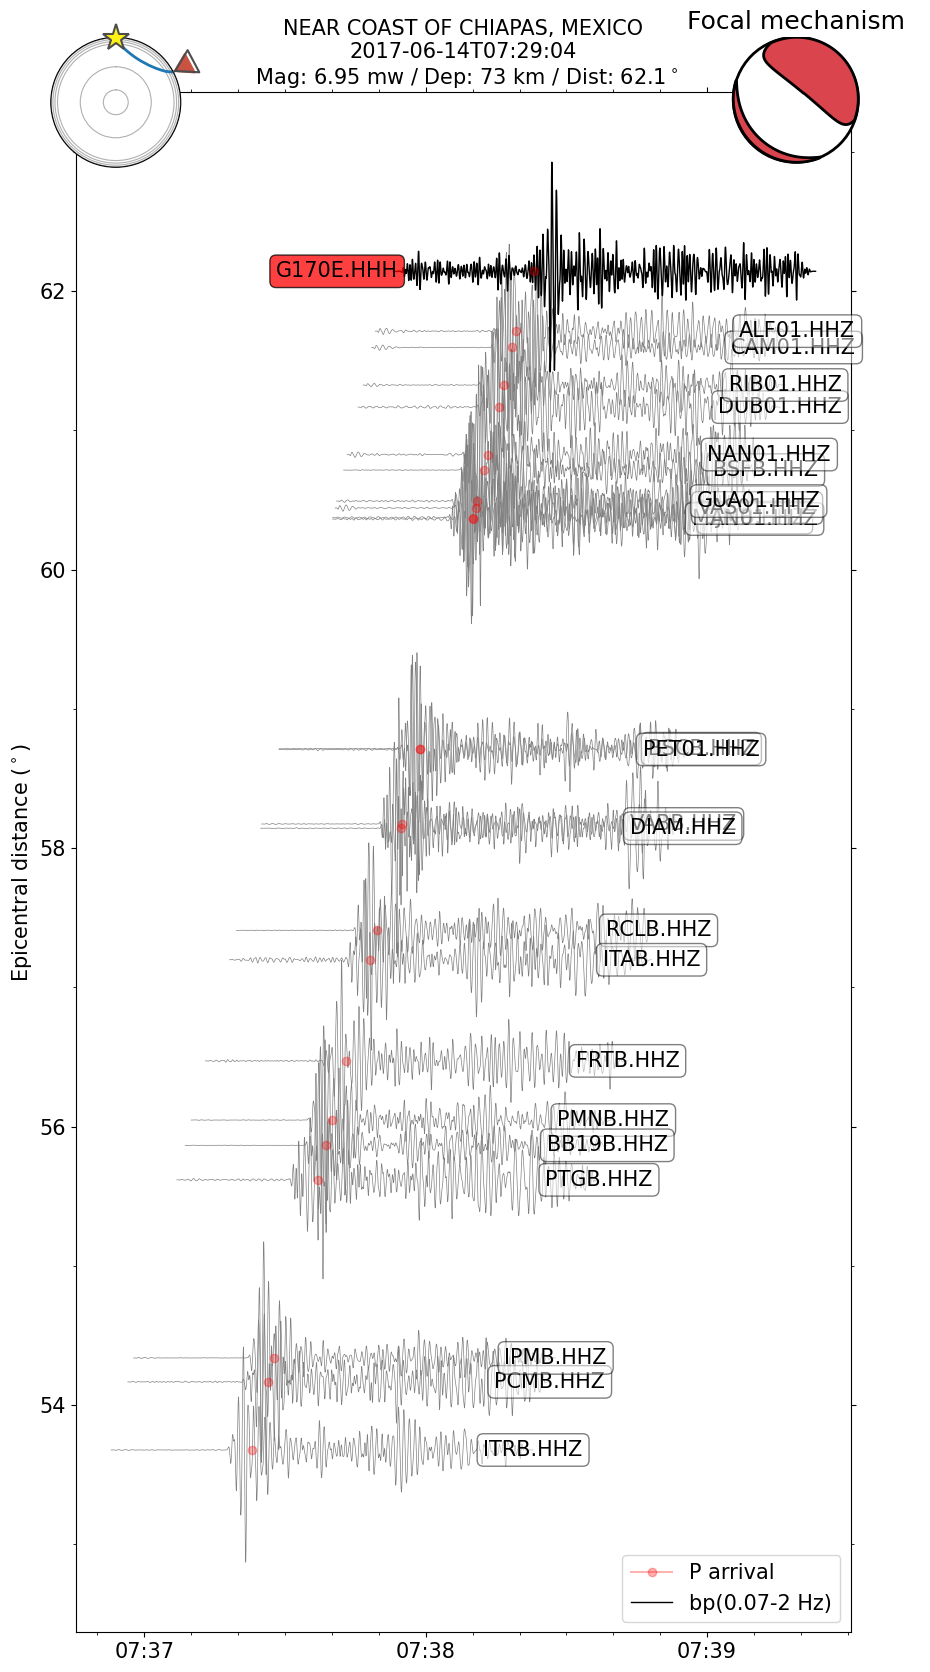

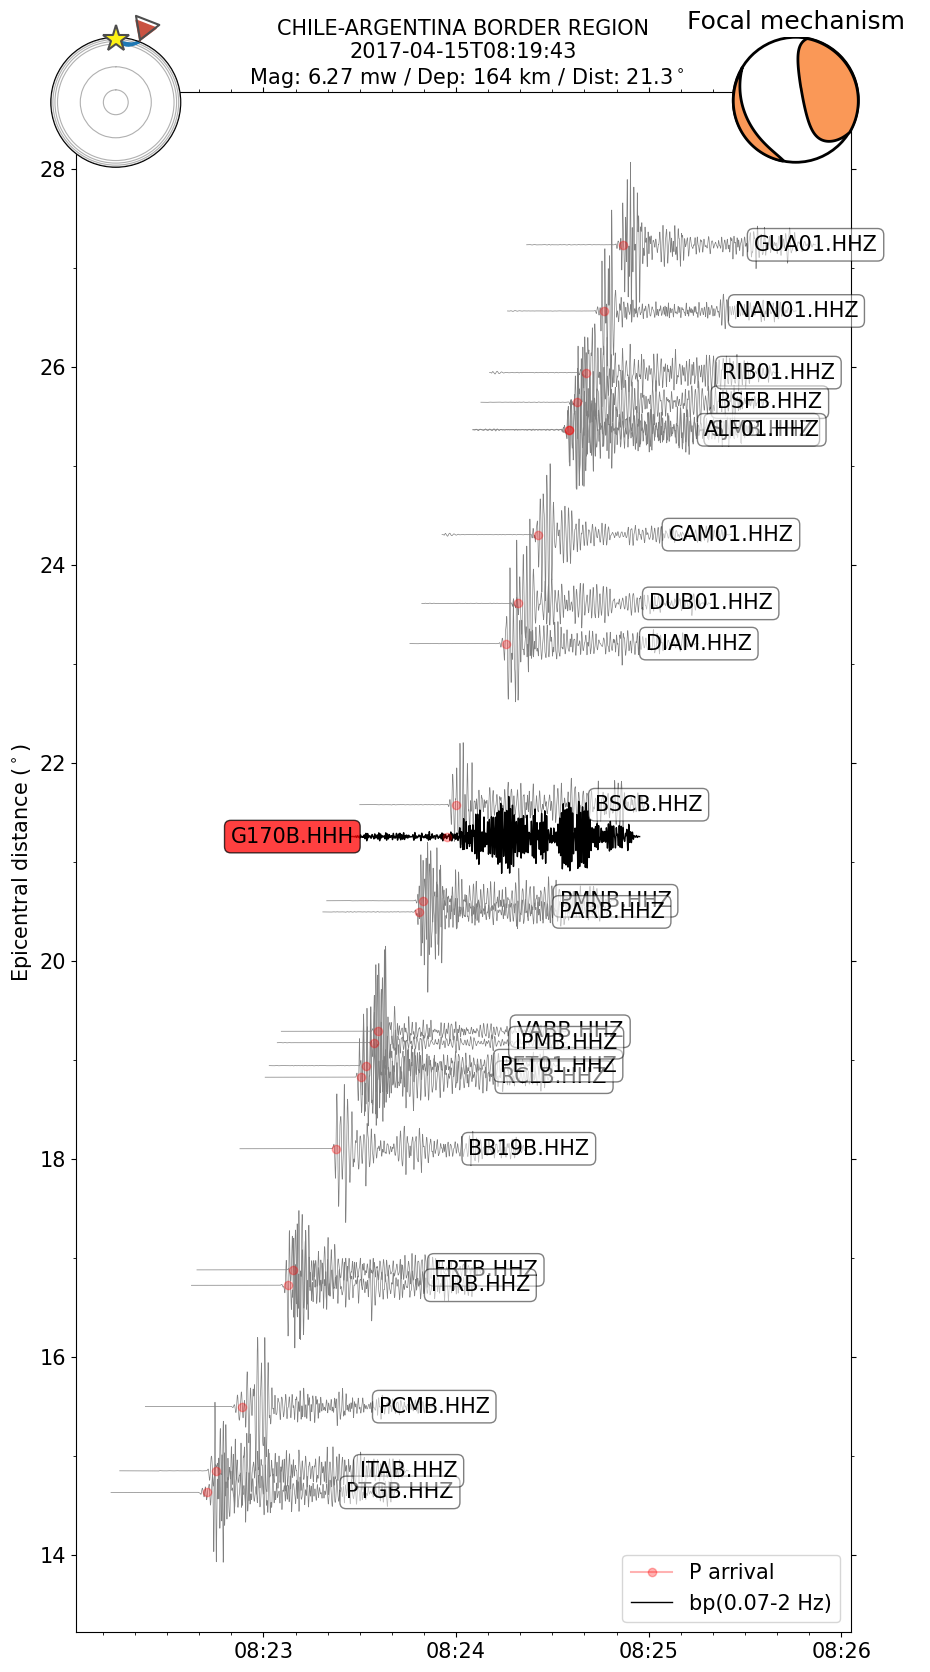

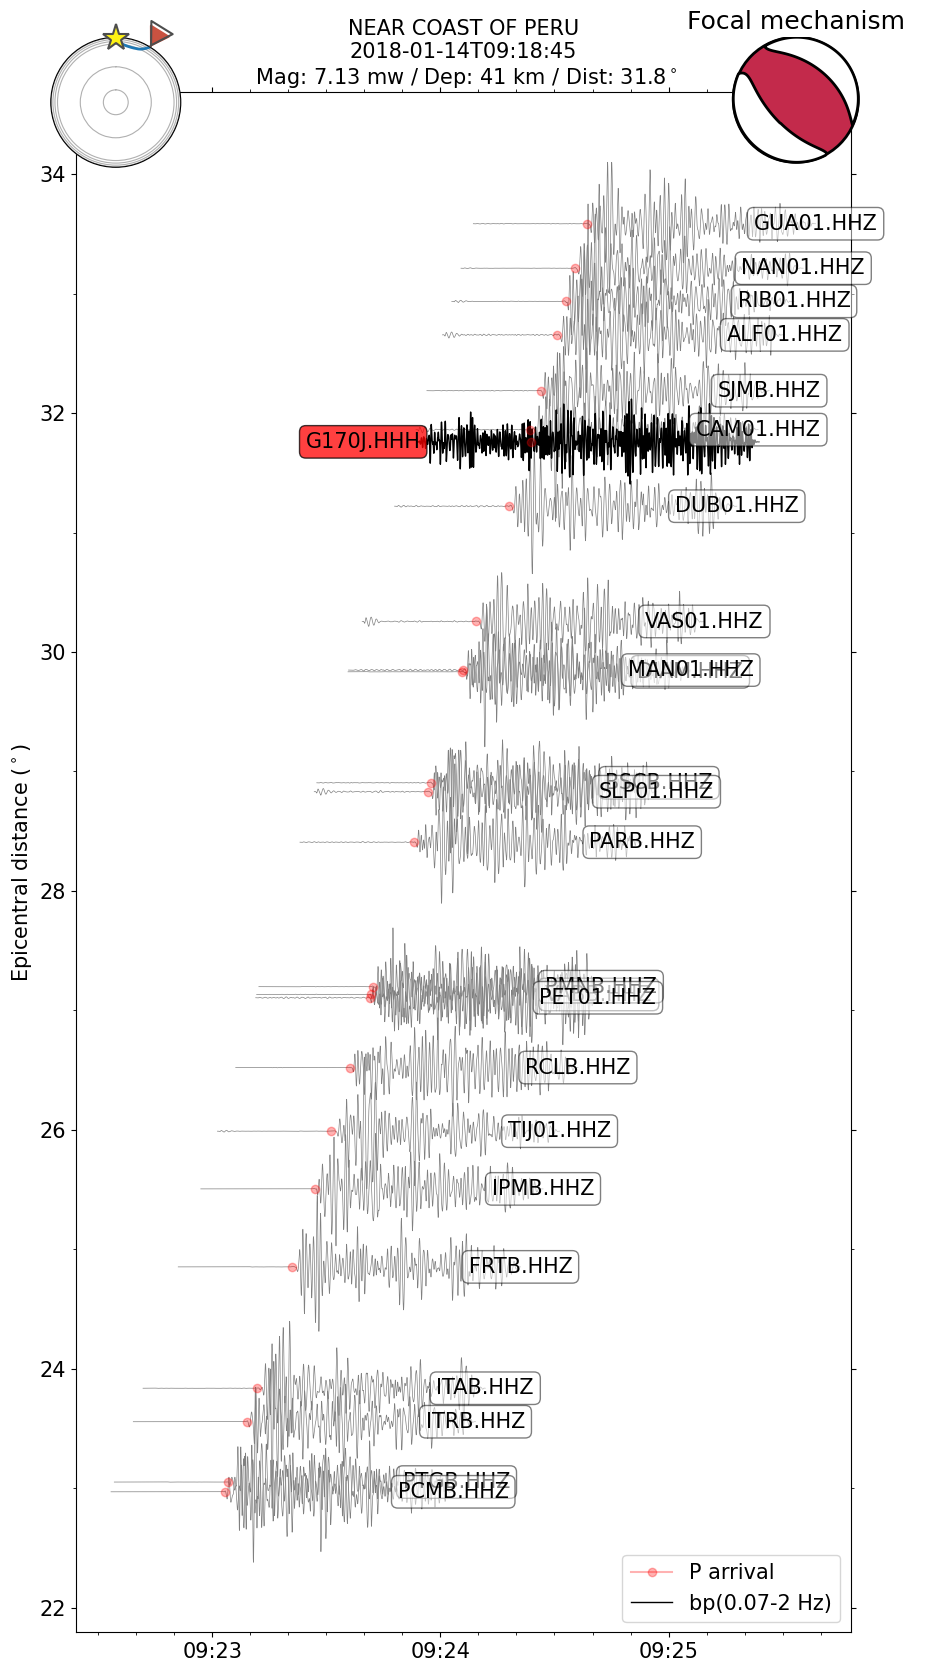

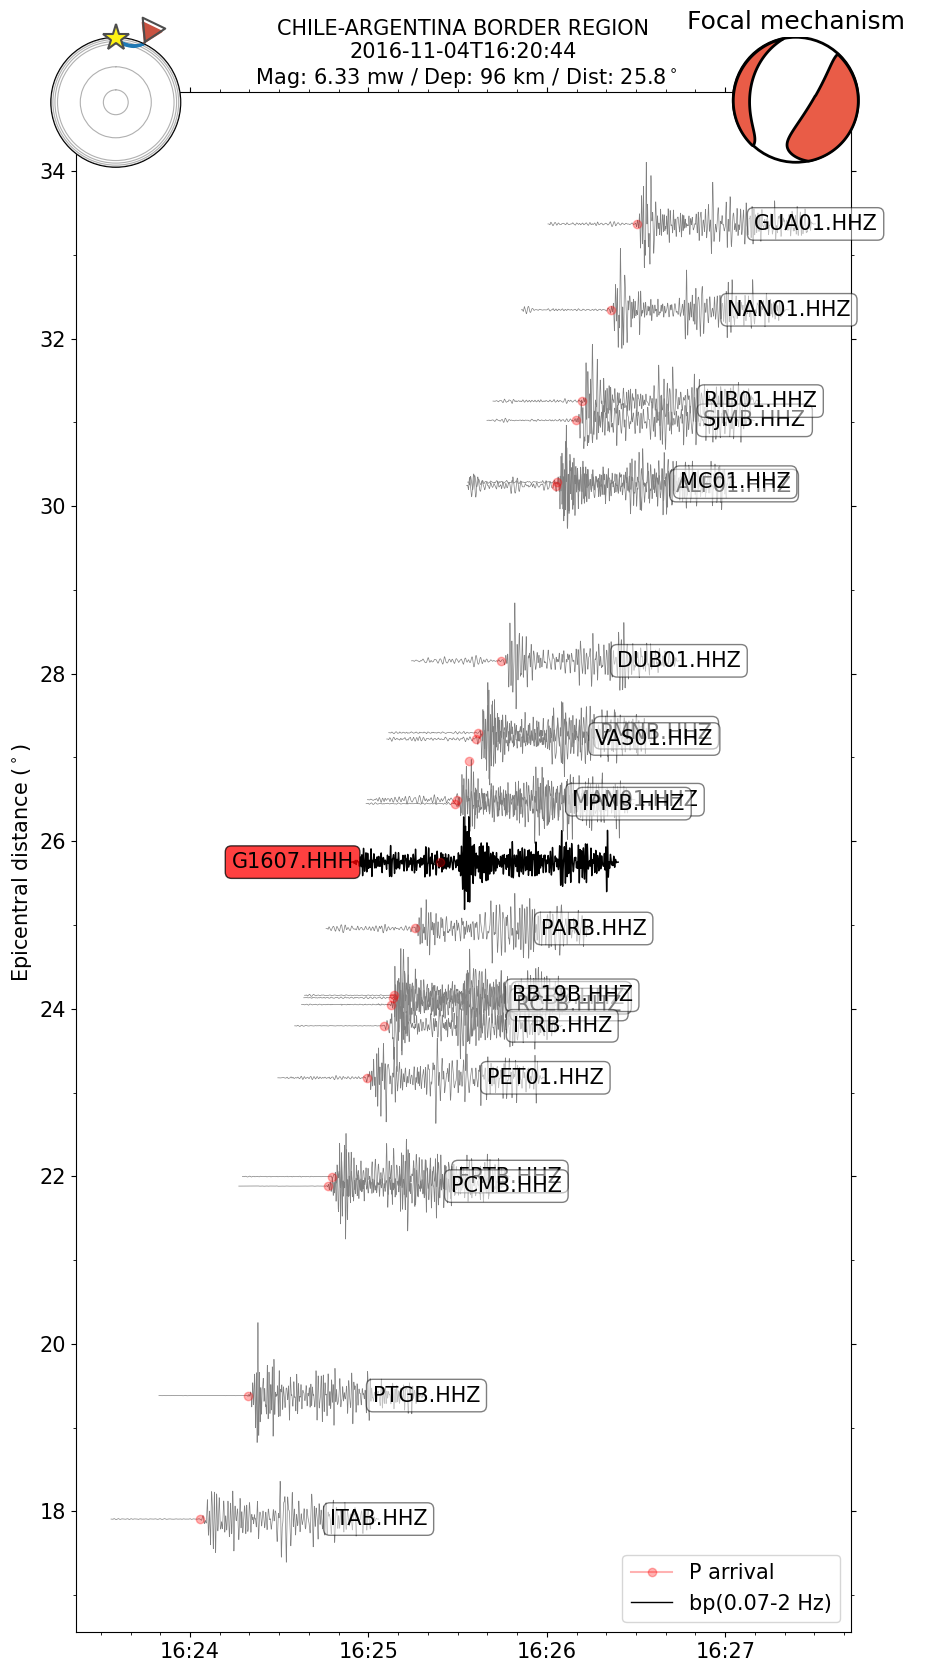

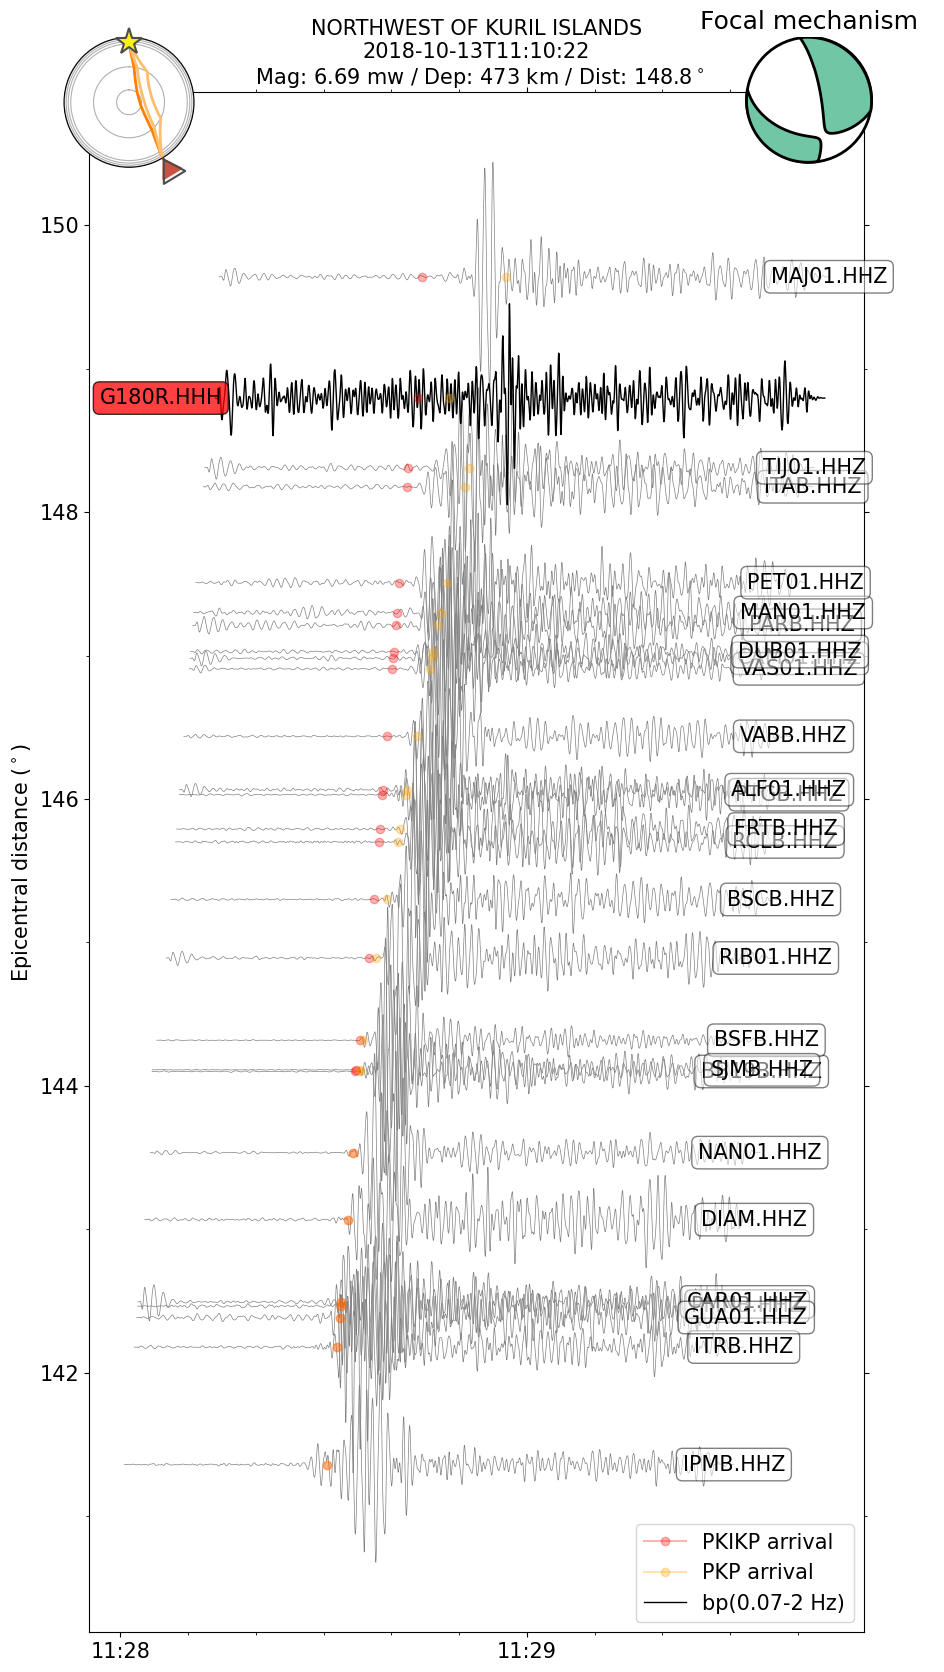

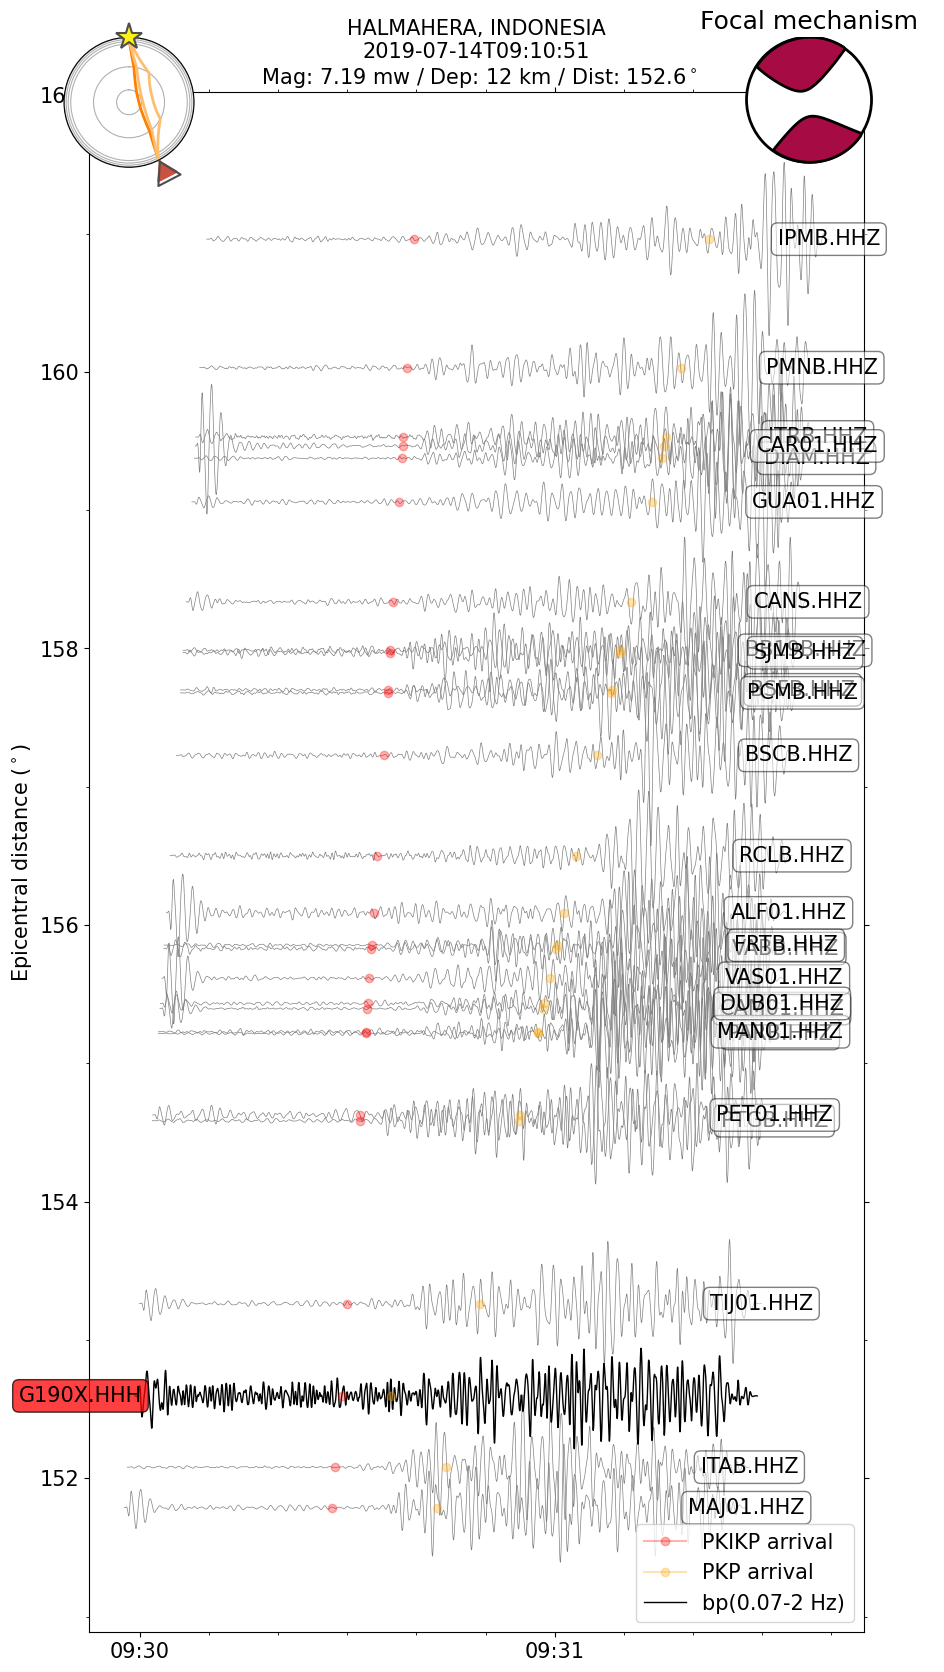

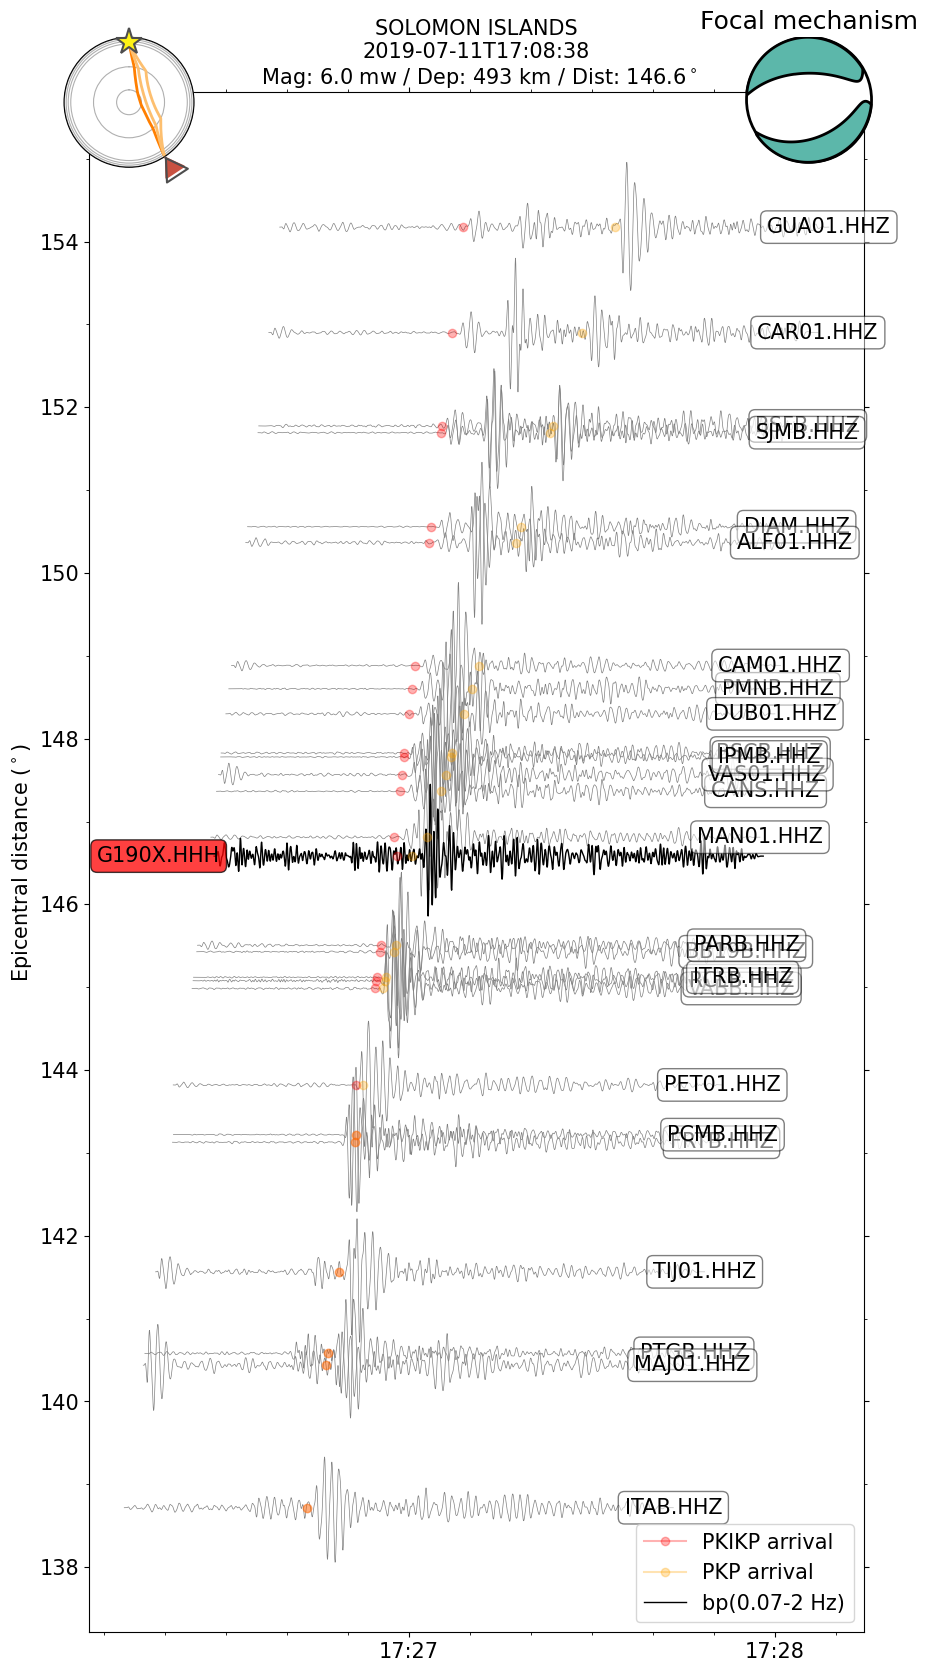

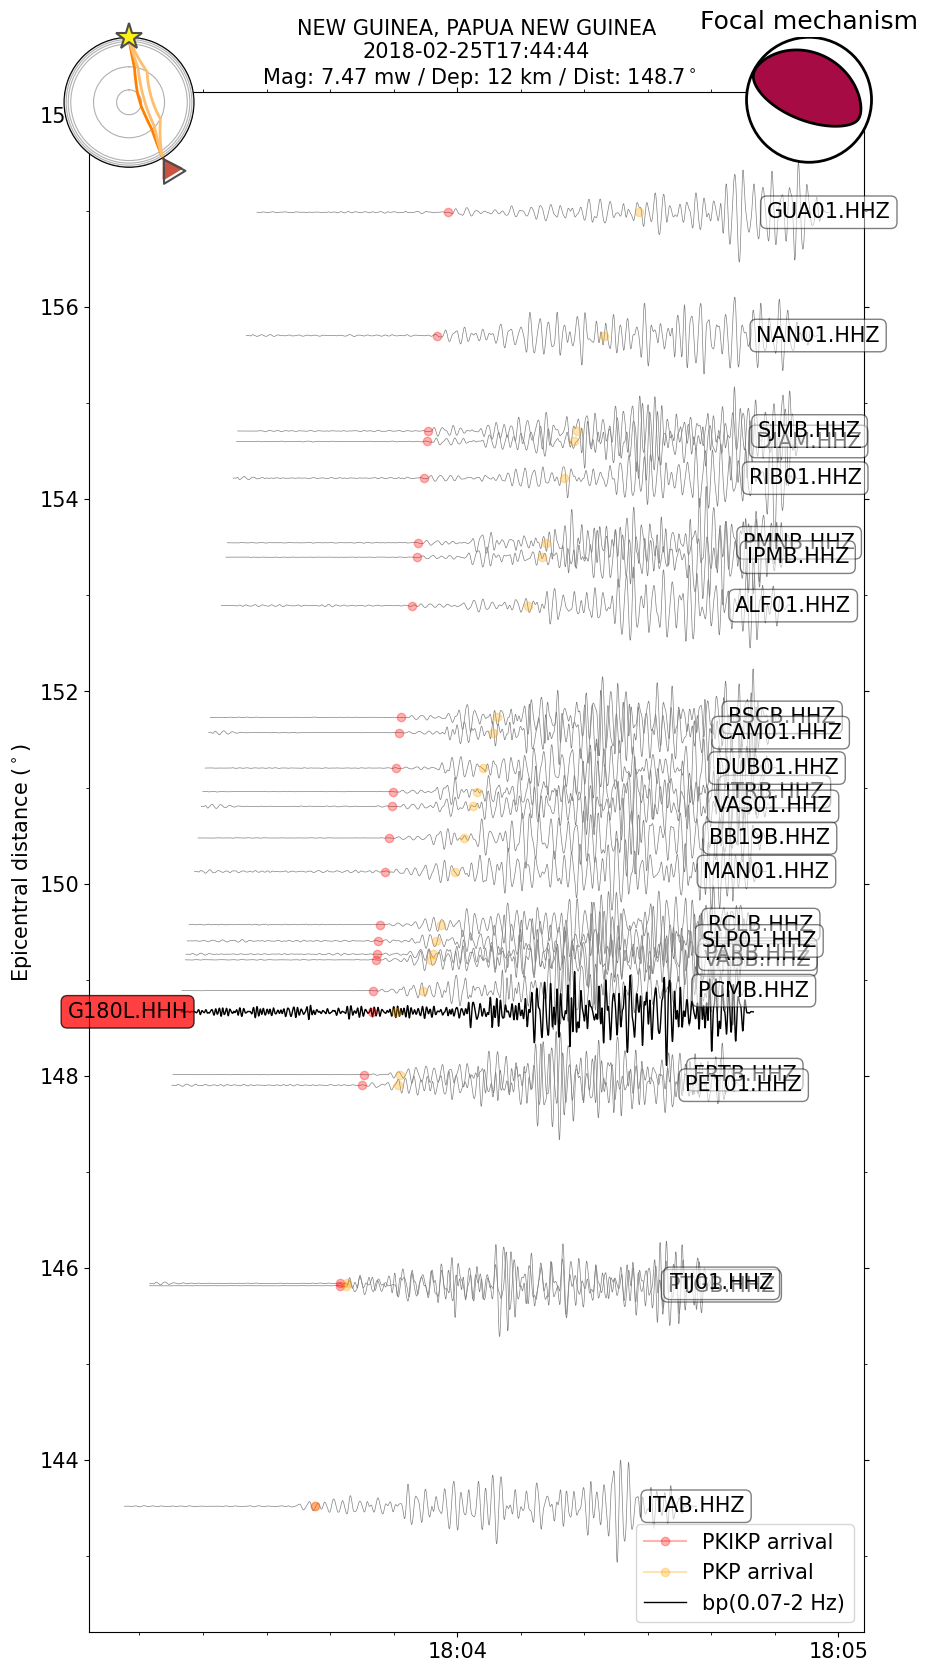

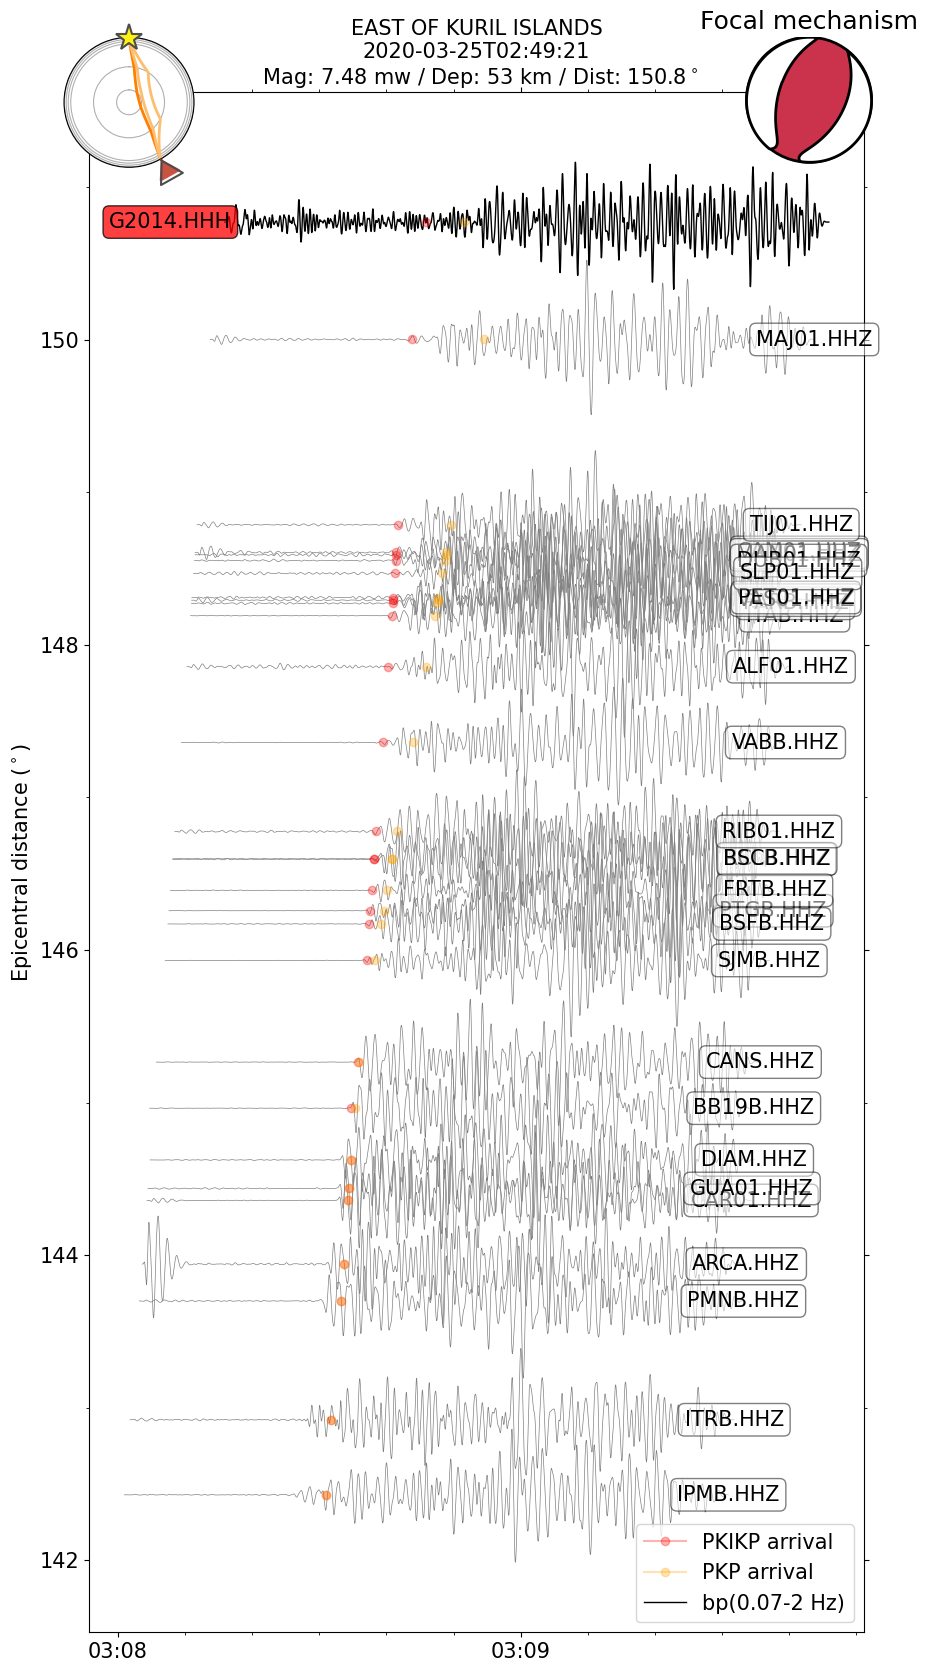

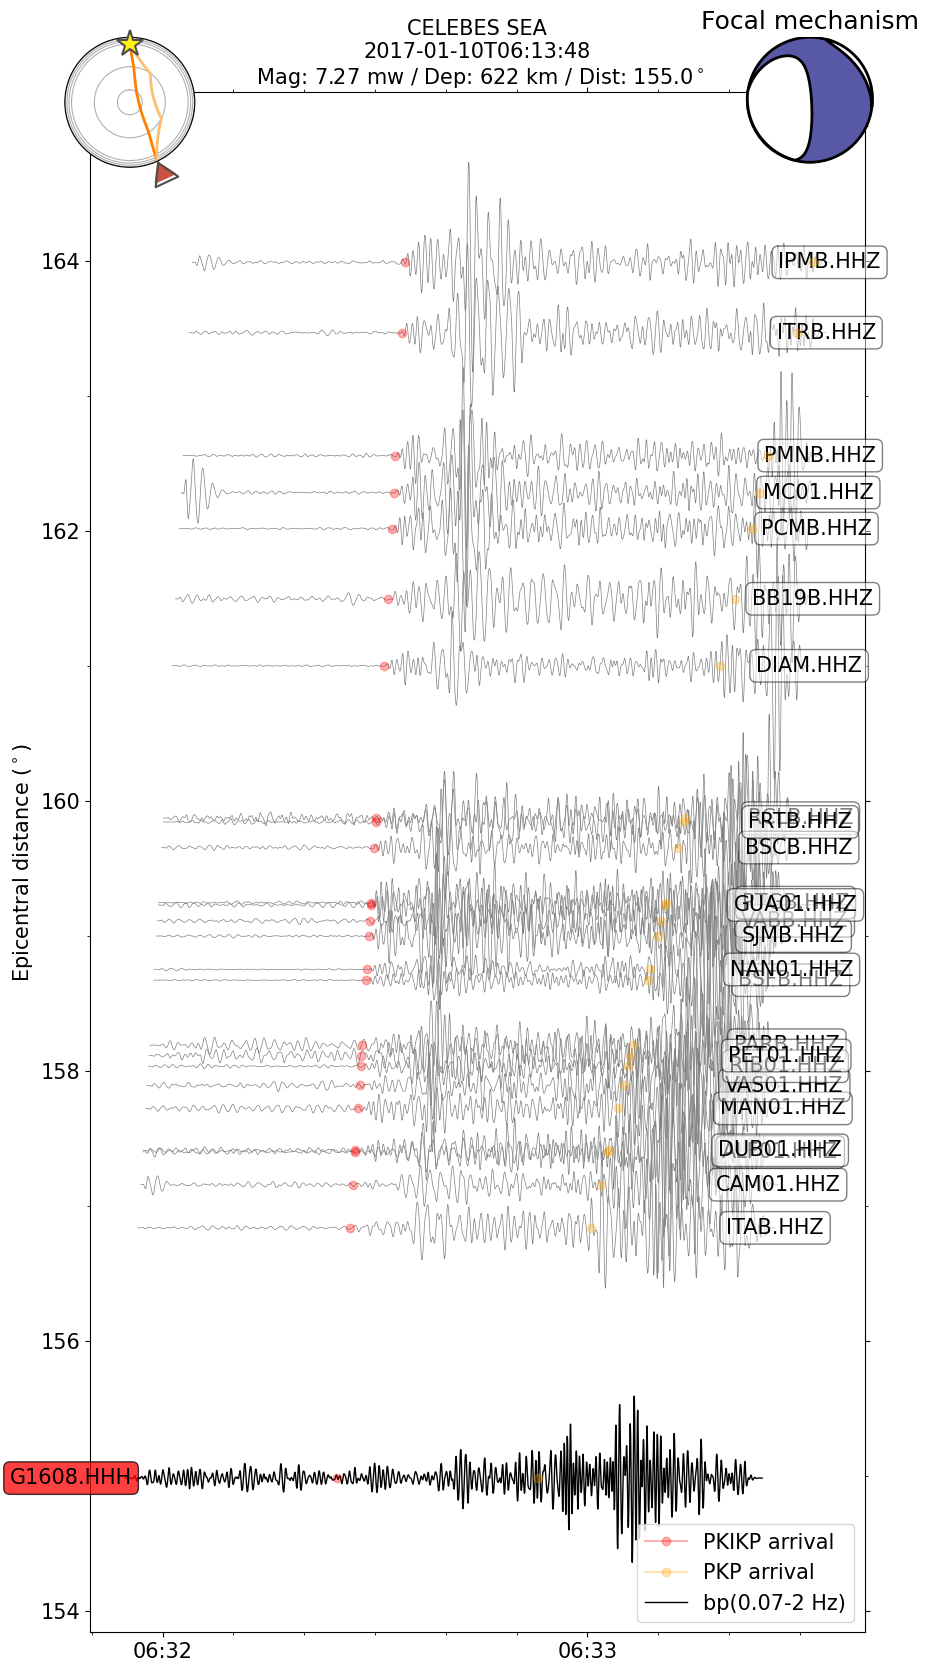

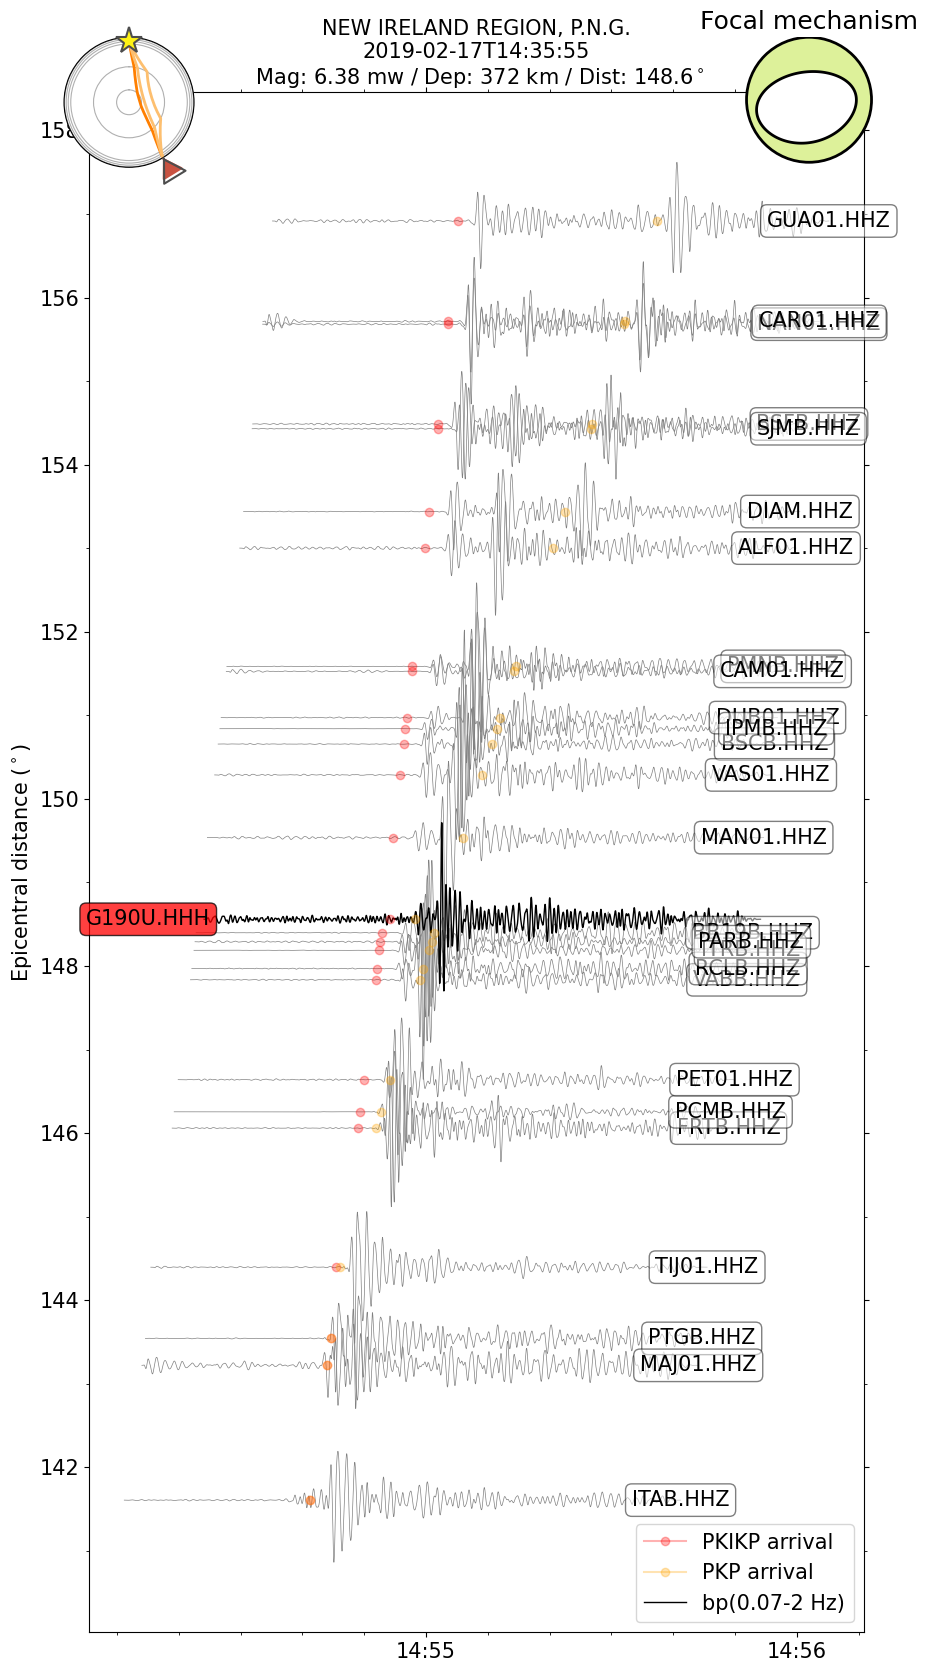

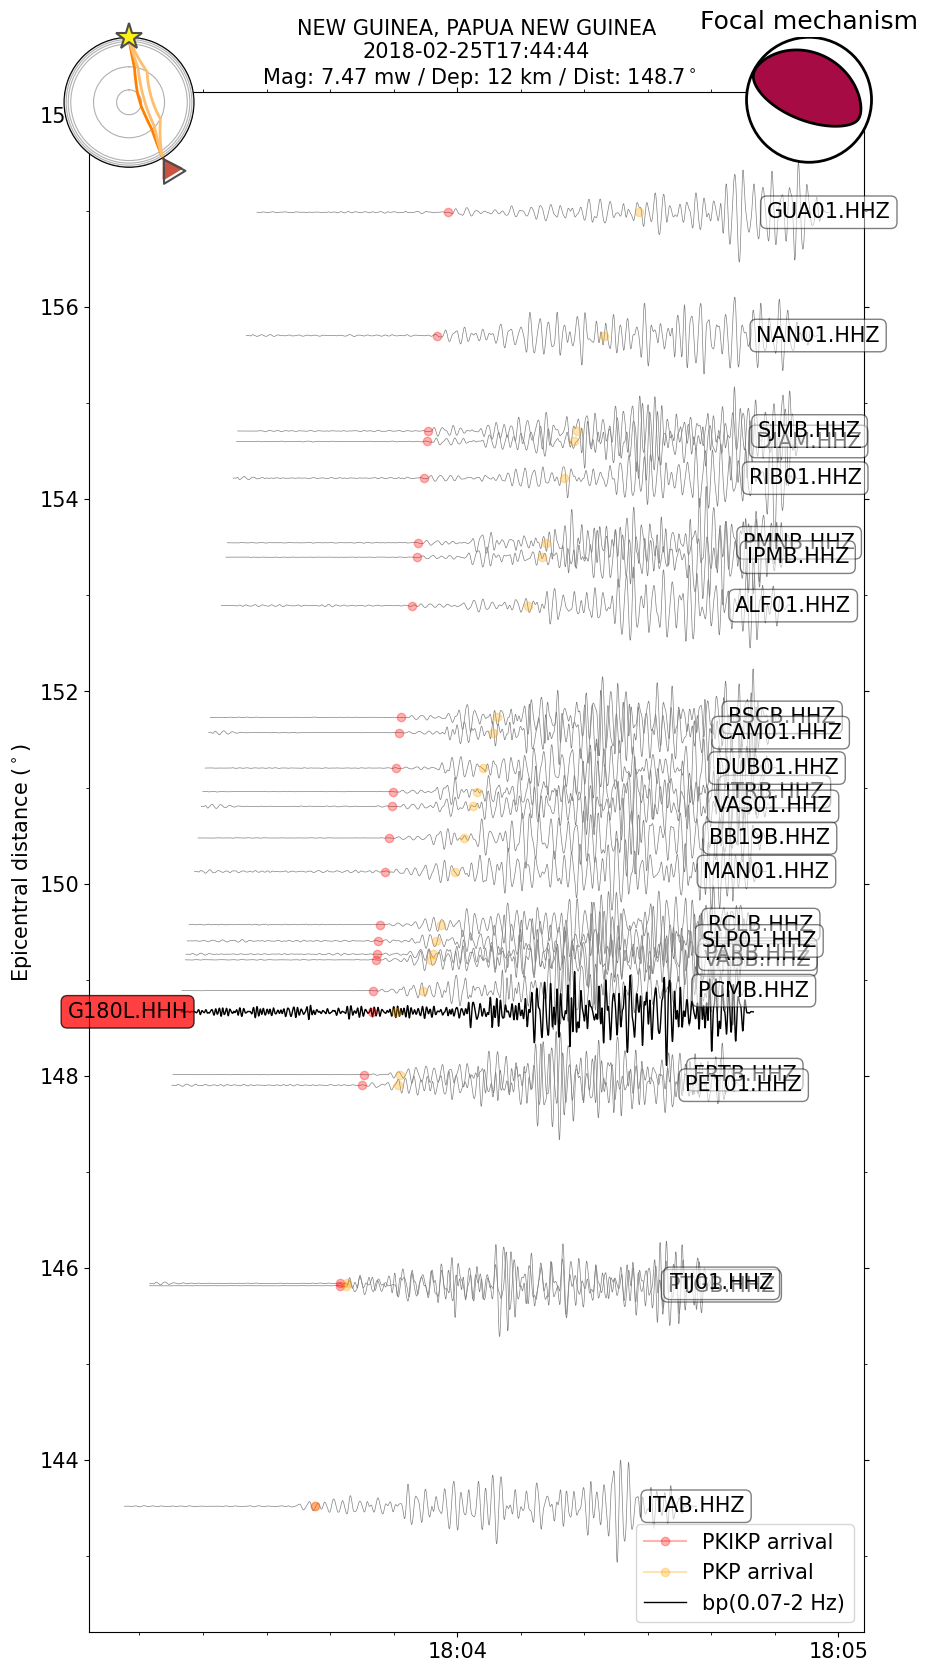

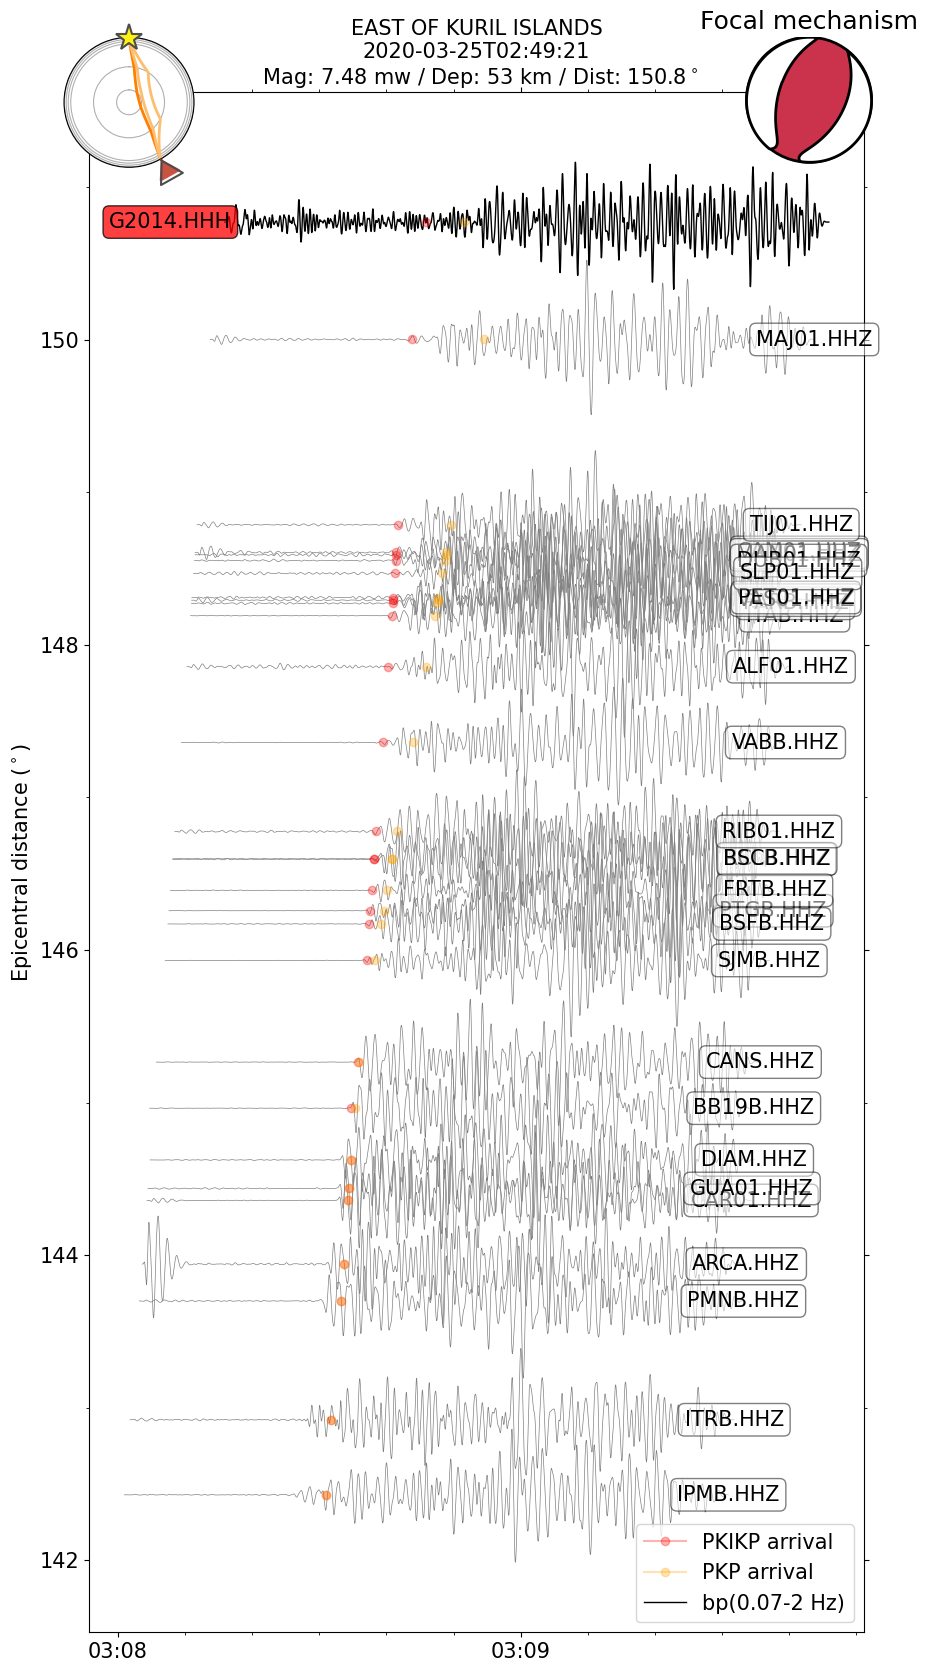

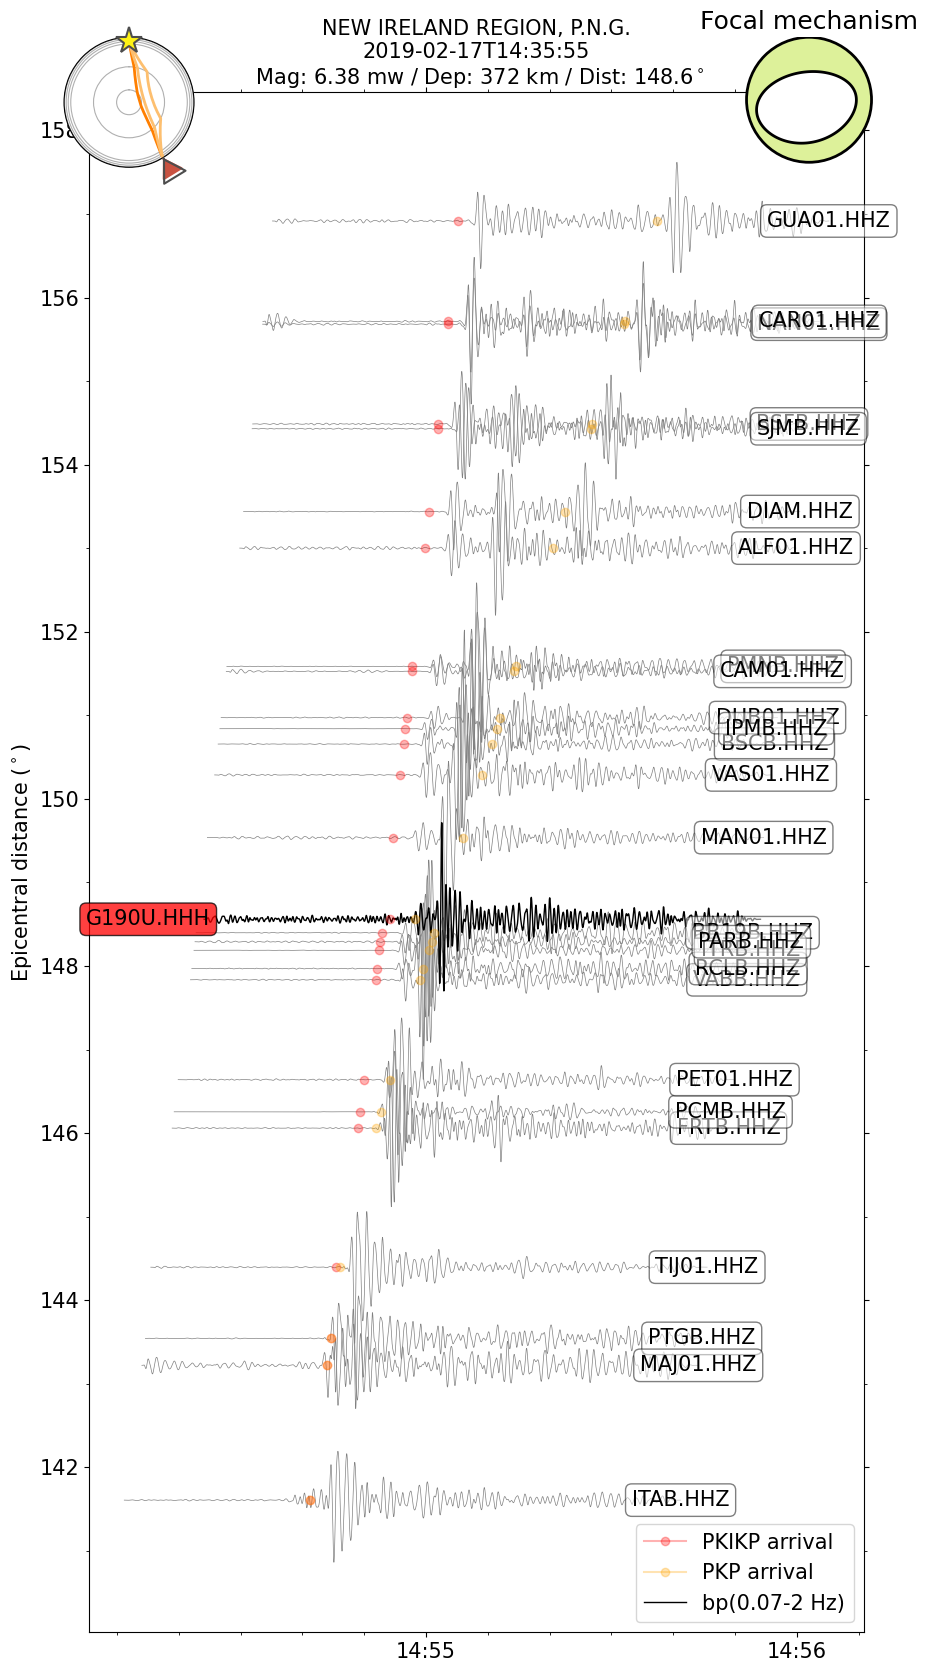

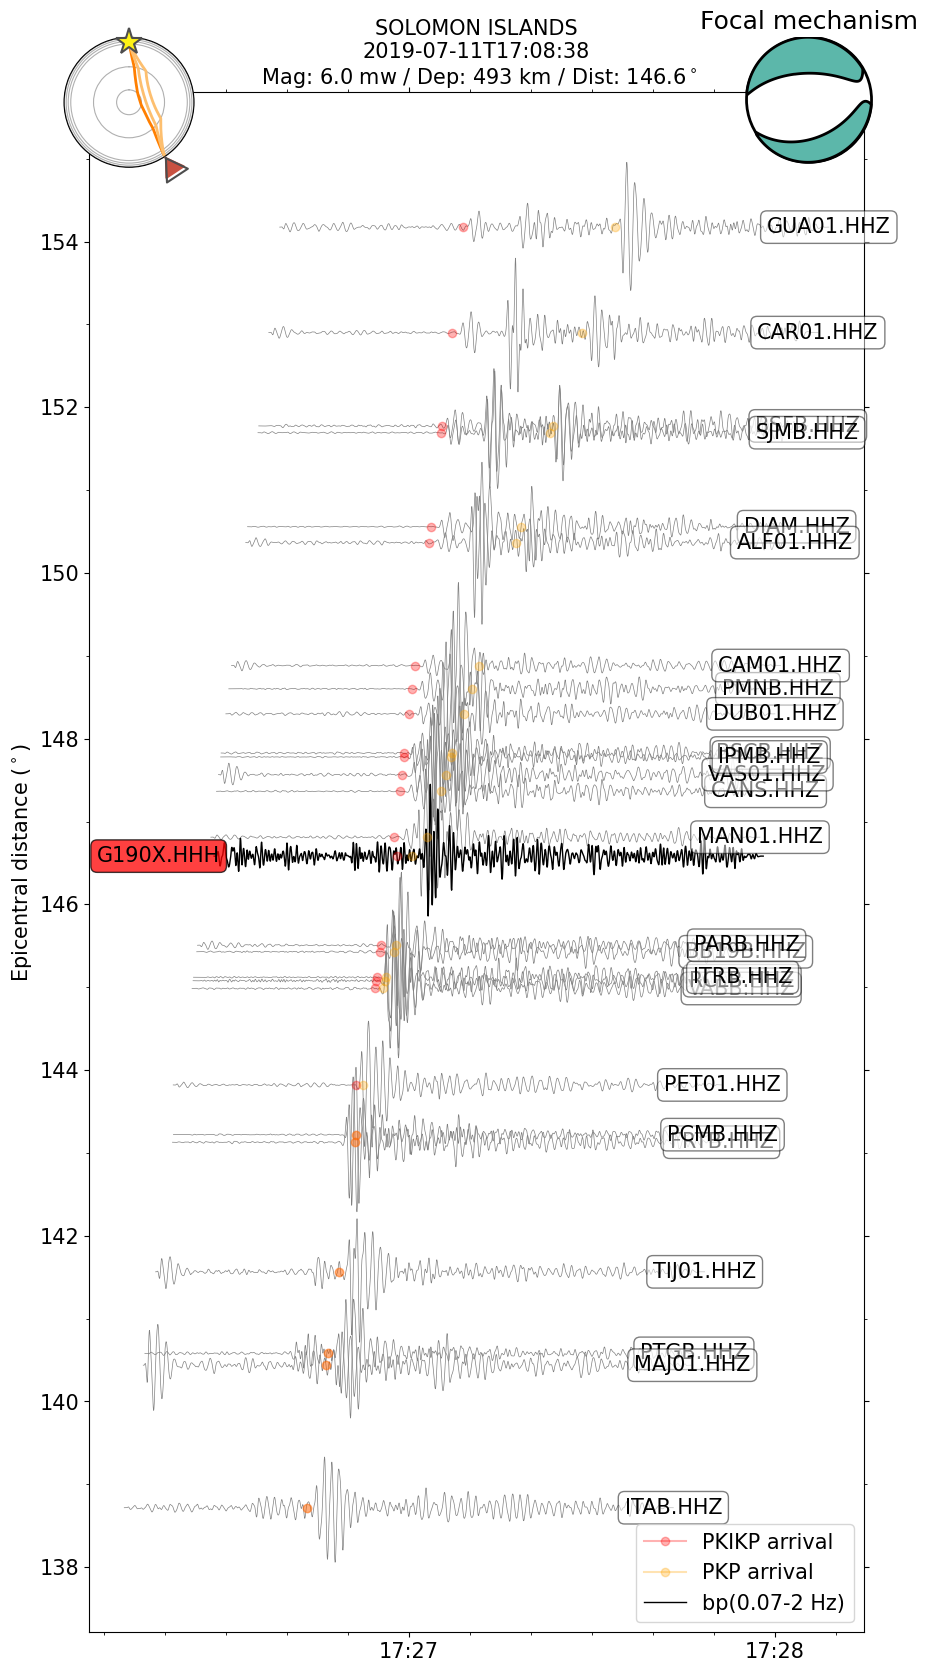

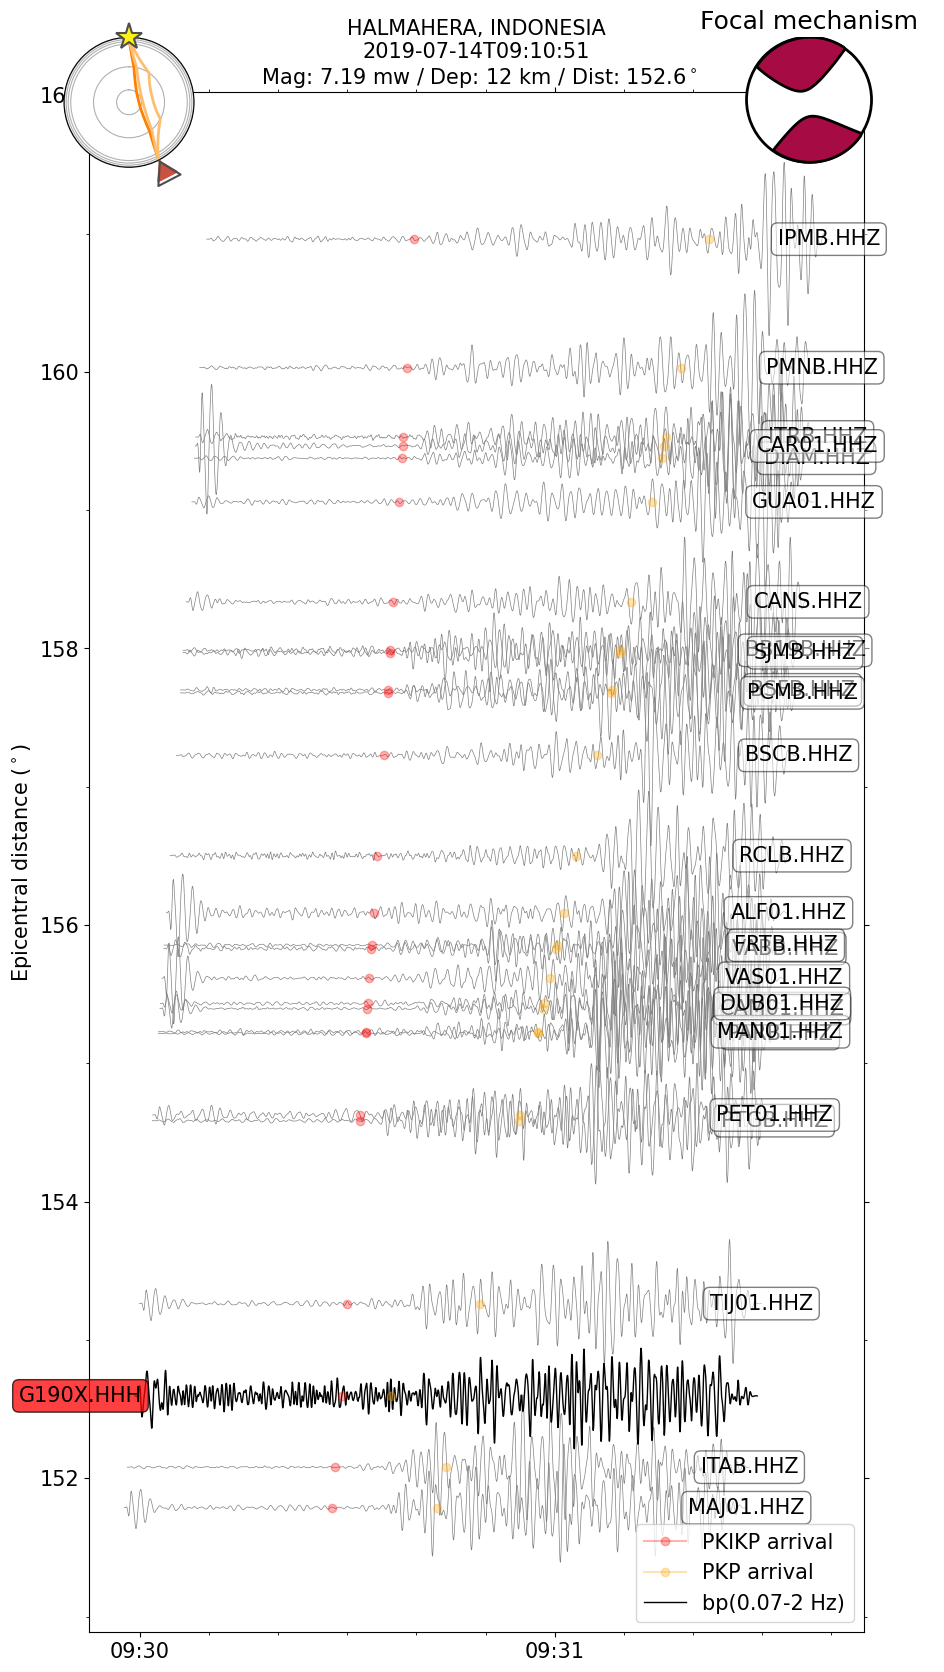

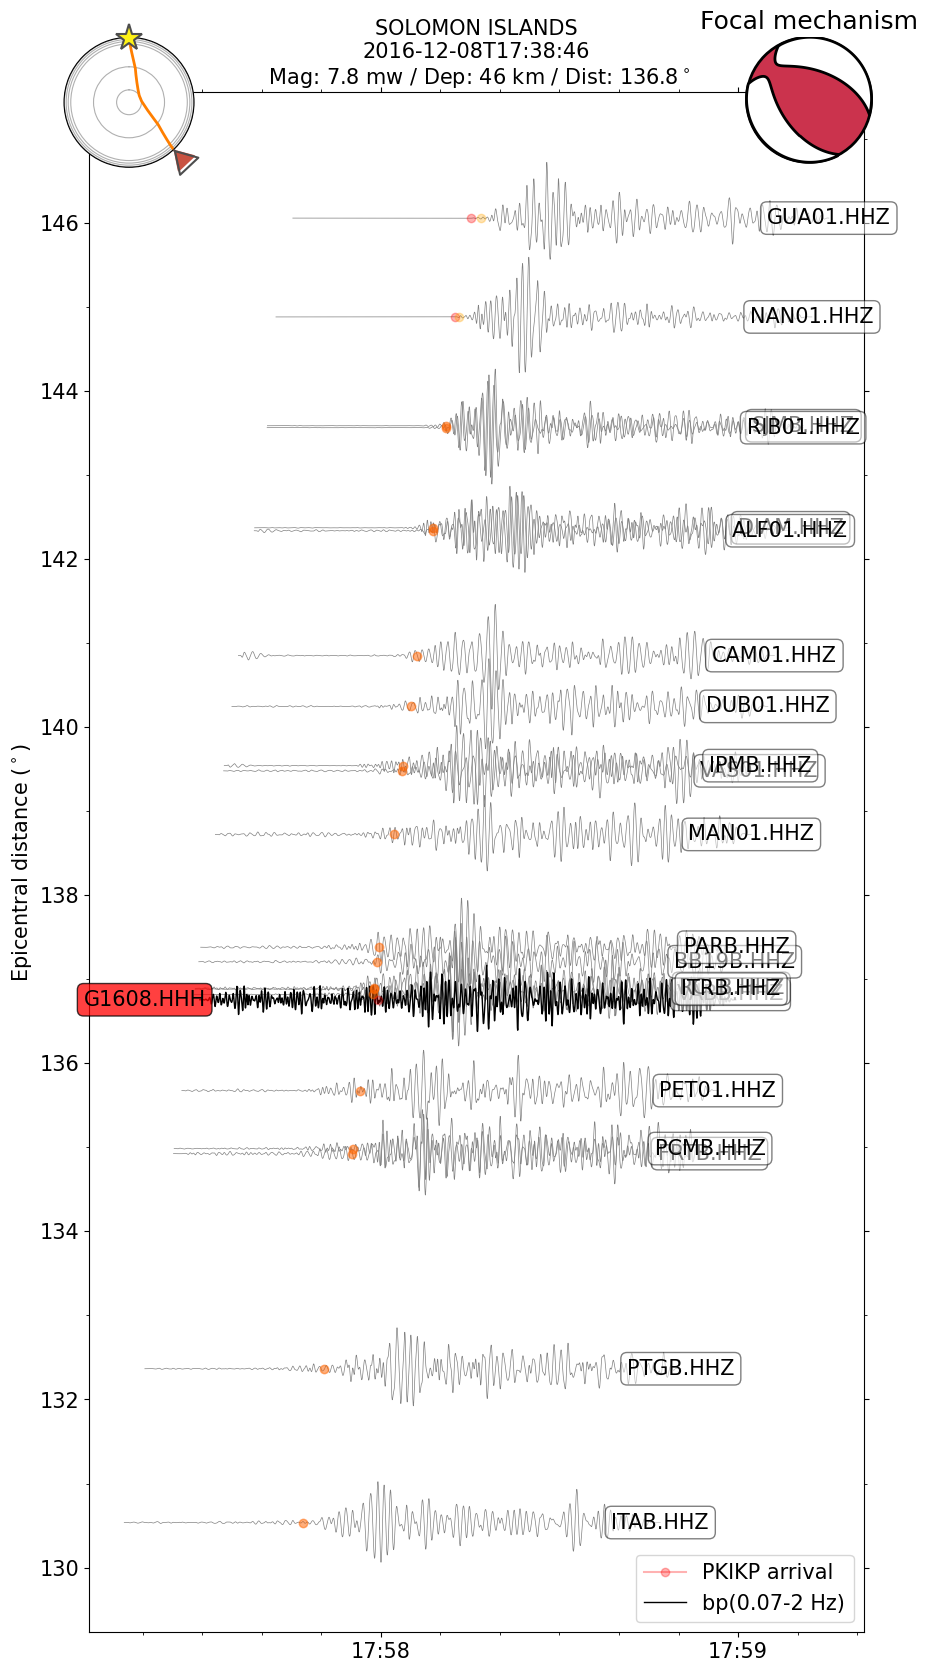

In [70]:
#########################################################################################################################################################
#Figure REGIONAL
# Setting: Global font size
mpl.rcParams.update({'font.size': 15})

for i in df.iterrows():

        glider = glob(EVENT_GLIDER+i[1]['filename_mseed'].split('.')[0]+'/'+i[1]['name_glider']+'/'+str(UTCDateTime(i[1]['ev_time']).year)+'/'+'{:03}'.format(UTCDateTime(i[1]['ev_time']).julday)+'/'+UTCDateTime(i[1]['ev_time']).strftime('%Y.%j.%H.%M.%S')+'*/*')
        rsbr = glob(EVENT_RSBR+'*/*/'+str(UTCDateTime(i[1]['ev_time']).year)+'/'+'{:03}'.format(UTCDateTime(i[1]['ev_time']).julday)+'/'+UTCDateTime(i[1]['ev_time']).strftime('%Y.%j.%H')+'*/*.Z')
   
        event = i[1]['ev_time']
        ev_lat = i[1]['ev_lat']
        ev_long = i[1]['ev_long']
        ev_depth = i[1]['ev_depth']
        magnitude = i[1]['magnitude']
        magnitude_type = i[1]['magnitude_type']
    
        # set up the plot and create a GeoAxes:
        fig = plt.figure(figsize=(10,20))
        ax = fig.add_subplot()
        
        # ============= #
        # RSBR STATIONS
        # ============= #
        for st_file in rsbr:
            st_plot = obspy.read(st_file)[0]
            
            gcarc = st_plot.stats.sac.gcarc
    
            #Event time at each station
            #Calculating distance, azimuth and backazimuth
            model = TauPyModel(model='ak135')
            
            time_ev = obspy.UTCDateTime(event)

            if i[1]['Phase'] == 'PKIKP' or i[1]['Phase'] == 'PKP':
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=['PKIKP','PKP'])
                event_time = time_ev+arrival[0].time
                event_time_PKP = time_ev+arrival[-1].time
               
                ax.plot(event_time.matplotlib_date,gcarc,c='r',marker='o',alpha=0.3,zorder=10)
                ax.plot(event_time_PKP.matplotlib_date,gcarc,c='orange',marker='o',alpha=0.3,zorder=10)
            else:
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=['P'])
                event_time = time_ev+arrival[0].time                             
                
                ax.plot(event_time.matplotlib_date,gcarc,c='r',marker='o',alpha=0.3,zorder=10)
                
            st_plot.trim(event_time-30,event_time+60)
            if len(st_plot) > 0:
                st_plot.filter('bandpass',freqmin=0.7,freqmax=2, corners=4, zerophase=False)
                st_plot.taper(max_percentage=0.05, type='cosine')      
                st_plot.detrend('linear')
                st_plot.detrend('demean')
                               
                ax.plot(st_plot.times('matplotlib'),gcarc+preprocessing.normalize([st_plot.data])[0]*10,c='grey',ls='-',lw=0.5)
                ax.text(x=st_plot.times('matplotlib')[-1],y=st_plot.stats.sac.gcarc,s=st_plot.stats.station+'.'+st_plot.stats.channel,ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.5))

    
        for st_file_glider in glider:
            st_plot_glider = obspy.read(st_file_glider)[0]
        
            gcarc_glider = st_plot_glider.stats.sac.gcarc
            dep_glider = st_plot_glider.stats.sac.stel
            
            #Event time at each station
            #Calculating distance, azimuth and backazimuth

            if i[1]['Phase'] == 'PKIKP' or i[1]['Phase'] == 'PKP':
                # -----------------------------------------------------------------
                # Estimation: arrival time by CAKE (https://pyrocko.org/docs/current/apps/cake/index.html)
                # Cake is a command line tool contained in Pyrocko, which can solve some classical seismic ray theory problems for 1D layered earth models (layer cake models).
                    
                command = 'cake arrivals --model='+MODEL_CAKE+' --sdepth='+str(ev_depth)+' --rdepth='+str(str(np.abs(dep_glider)/1000))+' --distances='+str(gcarc_glider)+' --degrees --classic="PKIKP","PKP"'
                proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
                (out, err) = proc.communicate()
                results = out.splitlines()

                if len(results) > 4:
                    event_time_glider = time_ev+float(results[3].split(' ')[2])
                    event_time_glider_PKP = time_ev+float(results[4].split(' ')[2])
                    ax.plot(event_time_glider.matplotlib_date,gcarc_glider,c='r',marker='o',alpha=0.3,label='PKIKP arrival',zorder=10)
                    ax.plot(event_time_glider_PKP.matplotlib_date,gcarc_glider,c='orange',marker='o',alpha=0.3,label='PKP arrival',zorder=10)
                
                else:
                    event_time_glider = time_ev+float(results[3].split(' ')[2])
                    ax.plot(event_time_glider.matplotlib_date,gcarc_glider,c='r',marker='o',alpha=0.3,label='PKIKP arrival',zorder=10)
       
            else:

                # -----------------------------------------------------------------
                # Estimation: arrival time by CAKE (https://pyrocko.org/docs/current/apps/cake/index.html)
                # Cake is a command line tool contained in Pyrocko, which can solve some classical seismic ray theory problems for 1D layered earth models (layer cake models).
                    
                command = 'cake arrivals --model='+MODEL_CAKE+' --sdepth='+str(ev_depth)+' --rdepth='+str(str(np.abs(dep_glider)/1000))+' --distances='+str(gcarc_glider)+' --degrees --classic="P"'
                proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
                (out, err) = proc.communicate()
                results = out.splitlines()

                event_time_glider = time_ev+float(results[3].split(' ')[2])
                ax.plot(event_time_glider.matplotlib_date,gcarc_glider,c='r',marker='o',alpha=0.3,label='P arrival',zorder=10)

            st_plot_glider.trim(event_time_glider-30,event_time_glider+60)

            if len(st_plot_glider) > 0:
                st_plot_glider.filter('bandpass', freqmin=0.7,freqmax=2, corners=4, zerophase=False)
                st_plot_glider.taper(max_percentage=0.05, type='cosine')     
                st_plot_glider.detrend('linear')
                st_plot_glider.detrend('demean')
            
                ax.plot(st_plot_glider.times('matplotlib'),gcarc_glider+preprocessing.normalize([st_plot_glider.data])[0]*10,c='k',ls='-',lw=1,label='bp(0.07-2 Hz)')
                ax.text(x=st_plot_glider.times('matplotlib')[100],y=gcarc_glider,s=st_plot_glider.stats.station+'.'+st_plot_glider.stats.channel,ha="right",va="center",bbox=dict(boxstyle="round",ec='k',fc='r',alpha=0.75))

        ax.set_title(i[1]['local']+'\n'+time_ev.strftime('%Y-%m-%dT%H:%M:%S')+'\n Mag: '+str(magnitude)+' '+magnitude_type+' / Dep: '+str(round(ev_depth))+' km / Dist: '+str(round(gcarc_glider,1))+'$^\circ$',fontsize=15)
        ax.set_ylabel('Epicentral distance ($^\circ$)')
        ax.legend(loc='lower right')
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=60))
        ax.xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.yaxis.set_major_locator(MultipleLocator(2))
        ax.yaxis.set_minor_locator(MultipleLocator(1))
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')

        # ----------------------------------------------------------------------------------------------------------
        # focal mechanisms
        # ----------------------------------------------------------------------------------------------------------

        # Plotting: graphical representation of a focal mechanism (https://docs.obspy.org/packages/autogen/obspy.imaging.beachball.beachball.html)

        # Normalize event depth values between 0 and 600 km:
        min_val = 0
        max_val = 600
        normalized_values = [(x - min_val) / (max_val - min_val) for x in np.arange(min_val, max_val,10)]

        # Colormap "Plasma" for each value
        colors = [plt.cm.Spectral(value) for value in normalized_values]
                                                                        
        # Convert colors RGB to hexadecimal:
        hex_colors = [mcolors.rgb2hex(color) for color in colors]

        # Find the color for a given depth
        diff_ev_depth = [np.abs(numero - ev_depth) for numero in np.arange(min_val, max_val,10)]
                                        
        # Find the min index for a given depth
        index_min_ev_depth = diff_ev_depth.index(min(diff_ev_depth))
    
        # -------------------------
    
        newax = fig.add_axes([0.72, 0.72, 0.25,  0.25])
    
        moment_tensor = ast.literal_eval(i[1]['moment_tensor'])
        mrr = moment_tensor[0]
        mtt = moment_tensor[1]
        mpp = moment_tensor[2]
        mrt = moment_tensor[3]
        mrp = moment_tensor[4]
        mtp = moment_tensor[5]
        mt = [mrr, mtt, mpp, mrt, mrp, mtp]
    
        # Plotting the hexcolor
        bball = beach(fm=mt, xy=(0, 0.5),size=500, width=1, facecolor=hex_colors[index_min_ev_depth])
            
        # Configura os eixos e adiciona a coleção
        newax.add_collection(bball)
        newax.set_xlim(-1, 1)
        newax.set_ylim(-1, 1)
        newax.set_aspect('equal')
        newax.axis('off')
        newax.set_title('Focal mechanism')

        # ===========================================================
        # ray paths (https://docs.obspy.org/packages/obspy.taup.html)
        # ===========================================================
        
        # ---------------------------------------------------------------------------------------------------
        # Computing: The paths travelled by the rays to the receiver for a given phase and 1D velocity model 
                    
        arrivals_ray_path = model.get_ray_paths(source_depth_in_km=ev_depth, distance_in_degree=gcarc_glider, phase_list=['P','PKP','PKIKP'])

        # -------------------------
        # Plotting: axes parameters 
                                    
        ax_raypath = fig.add_axes([0.1, 0.81, 0.13,  0.13], projection='polar')
        arrivals_ray_path.plot_rays(ax=ax_raypath)
        ax_raypath.set_title('Ray path',y=1.08)
   
        # ----------------------------------------------------------------------------------------------------------
        # Saving figure
        os.makedirs(FOLDER_OUTPUT+'EVENTS/FIGURES/REGIONAL/',exist_ok=True)
        fig.savefig(FOLDER_OUTPUT+'EVENTS/FIGURES/REGIONAL/'+'event_mseed_'+time_ev.strftime('%Y-%m-%dT%H:%M:%S')+'_'+i[1]['ev_ID']+'.png',pad_inches=0.0,dpi=200)
        plt.close()